## Purpose

Here I will be testing the various pipelines executed for the dippers search using ZTF data.

In [2]:
# magic for real time editing of .py files
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')
import lsdb
import dask
dask.config.set({"temporary-directory" :'/epyc/ssd/users/atzanida/tmp'})
import dask.dataframe as dd
from tape import Ensemble, ColumnMapper
import astropy.stats as astro_stats

In [4]:
# Custom functions and tools 

import sys
sys.path.insert(1, '../../dipper')

import tools as my_tools
import dipper as dip_pipeline
import models as dip_models
from evaluate import evaluate as evaluate
from gpmcmc import model_gp

In [5]:
%%time
# load lite version of Gaia DR3 for quick cone searches
gaia_lite = lsdb.read_hipscat("/epyc/data3/hipscat/test_catalogs/gaia_symbolic", columns=['ra',
                                                                                         'dec', 
                                                                                         "parallax", 
                                                                                         "phot_g_mean_mag"])

CPU times: user 13.2 s, sys: 1.75 s, total: 14.9 s
Wall time: 2min 6s


In [6]:
%%time
# demo tool estimate the nearest neighbour given ra, dec
my_tools.estimate_gaiadr3_density(131.1, 22.3, gaia_lite)

CPU times: user 515 ms, sys: 120 ms, total: 636 ms
Wall time: 815 ms


{'closest_bright_star_arcsec': 36.39390440082004,
 'closest_bright_star_mag': 16.448757,
 'closest_star_arcsec': 27.14692435897172,
 'closest_star_mag': 16.448757,
 'density_arcsec2': 6872.744168992514}

In [6]:
%%time
#Load ZTF, Gaia, and ZTF sources hipscats # note data3/ for epyc
gaia = lsdb.read_hipscat("/epyc/data3/hipscat/test_catalogs/gaia_symbolic")

# load ZTF object table
ztf = lsdb.read_hipscat("/epyc/data3/hipscat/catalogs/ztf_axs/ztf_dr14")

# Load ZTF DR14 sources
ztf_sources = lsdb.read_hipscat("/epyc/data3/hipscat/catalogs/ztf_axs/ztf_source")

CPU times: user 1min 12s, sys: 12 s, total: 1min 24s
Wall time: 8min 57s


In [269]:
gaia.head(1)

AttributeError: 'Catalog' object has no attribute 'head'

In [25]:
%%time
# crossmatch ZTF + Gaia - for the sake of speed - let's do a simple cone search.
_all_sky_object = gaia.cone_search(ra=65.884243, dec=34.552133, radius=5).crossmatch(ztf).query(
    "nobs_g_ztf_dr14 > 50 and nobs_r_ztf_dr14 > 50 and nobs_i_ztf_dr14 > 10 and \
    parallax_gaia > 0 and parallax_over_error_gaia > 5 and \
    teff_gspphot_gaia > 5380 and teff_gspphot_gaia < 7220 and logg_gspphot_gaia > 4.5 \
    and logg_gspphot_gaia < 4.72 and classprob_dsc_combmod_star_gaia > 0.5").compute()

2024-01-04 13:50:29,210 - distributed.nanny - WARNING - Worker process still alive after 3.199998474121094 seconds, killing
2024-01-04 13:50:29,214 - distributed.nanny - WARNING - Worker process still alive after 3.1999989318847657 seconds, killing
2024-01-04 13:50:29,215 - distributed.nanny - WARNING - Worker process still alive after 3.1999989318847657 seconds, killing
/astro/users/atzanida/lsdbgithub/lsdb/src/lsdb/core/cone_search.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_frame["_CONE_SEP"] = df_separations
/astro/users/atzanida/lsdbgithub/lsdb/src/lsdb/core/cone_search.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining 

CPU times: user 8.97 s, sys: 2.35 s, total: 11.3 s
Wall time: 50.5 s


In [26]:
%%time 
# Convert crossmatch _sample to lsdb Catalog object
_sample_hips = lsdb.from_dataframe(
    _all_sky_object, 
    lowest_order=5, 
    highest_order=8, 
    ra_column="ra_gaia", 
    dec_column="dec_gaia", 
    threshold=1_000_000
)

CPU times: user 4.05 s, sys: 482 ms, total: 4.53 s
Wall time: 5.65 s


In [27]:
%%time
# merge sources to sample hips object
_sources = _sample_hips.join(
    ztf_sources, left_on="ps1_objid_ztf_dr14", right_on="ps1_objid")

CPU times: user 5.36 s, sys: 583 ms, total: 5.95 s
Wall time: 5.71 s


In [13]:
# Initialize an Ensemble
ens = Ensemble(memory_limit=1e11, n_workers=12)
ens.client_info()

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46213 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:46213/status,
Dashboard: http://127.0.0.1:46213/status,Workers: 12
Total threads: 96,Total memory: 1.09 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43690,Workers: 12
Dashboard: http://127.0.0.1:46213/status,Total threads: 96
Started: Just now,Total memory: 1.09 TiB
Comm: tcp://127.0.0.1:46428,Total threads: 8
Dashboard: http://127.0.0.1:44246/status,Memory: 93.13 GiB
Nanny: tcp://127.0.0.1:43327,


In [28]:
# ColumnMapper Establishes which table columns map to timeseries quantities
colmap = ColumnMapper(
        id_col='_hipscat_index',
        time_col='mjd',
        flux_col='mag',
        err_col='magerr',
        band_col='band',
      )

In [29]:
%%time
# We can read from parquet
ens.from_dask_dataframe(
    source_frame=_sources._ddf,
    object_frame=_sample_hips._ddf,
    column_mapper=colmap,
    sync_tables=False, # Avoid doing an initial sync
    sorted=True, # If the input data is already sorted by the chosen index
    sort=False,
)

CPU times: user 80.9 ms, sys: 7.15 ms, total: 88 ms
Wall time: 80 ms


/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/dask/dataframe/core.py:5400: UserWarning: New index has same name as existing, this is a no-op.
  warnings.warn(
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/dask/dataframe/core.py:5400: UserWarning: New index has same name as existing, this is a no-op.
  warnings.warn(


In [30]:
_ids = ens.object.head(5).index

In [31]:
print (_ids)

Index([350084435456032768, 350109865684762624, 350115469937606656,
       350125529581486080, 350126081782579200],
      dtype='uint64', name='_hipscat_index')


## Search the most promising candidates

In [2382]:
from tqdm import tqdm

In [2406]:
for _id_ in tqdm(_ids):
    lc = ens.source.loc[_id_].compute()
    
    try:
        time, mag, magerr = my_tools.prepare_lc(lc['mjd_ztf_source'],
                       lc['mag_ztf_source'], 
                       lc['magerr_ztf_source'], 
                       lc['catflags_ztf_source'],
                       lc['band_ztf_source'], band_of_study='r', flag_good=0)

        time, mag, magerr = my_tools.fill_gaps(time, mag, magerr, num_points=25, max_gap_days=90)

        # Evaluate biweight location and scale
        R, S = astro_stats.biweight.biweight_location(mag), astro_stats.biweight.biweight_scale(mag)

        # Running deviation
        running_deviation = dip_pipeline.deviation(mag, magerr, R, S)

        # Peak detection summary per light curve
        peak_detections = dip_pipeline.peak_detector(time, running_deviation, power_thresh=4, peak_close_rmv=15, pk_2_pk_cut=30)
    except:
        continue
        
    try:
        # Select best peak candidate with at least 3 points in the dip
        bp = dip_pipeline.best_peak_detector(peak_detections, min_in_dip=5)

        if bp['N_1sig_in_dip']>=7:
            print (_id_, "FOUNDD!!!!!!!!!!!!!!!!!!!")
    except:
        continue

  1%|          | 1/179 [00:07<23:15,  7.84s/it]

No dip is found within the minimum number of detections.


  1%|          | 2/179 [00:15<23:14,  7.88s/it]

No dip is found within the minimum number of detections.


  2%|▏         | 3/179 [00:23<23:26,  7.99s/it]

No dip is found within the minimum number of detections.


  3%|▎         | 5/179 [00:35<18:10,  6.27s/it]

No dip is found within the minimum number of detections.


  3%|▎         | 6/179 [00:39<15:50,  5.50s/it]

No dip is found within the minimum number of detections.


  4%|▍         | 7/179 [00:42<14:15,  4.97s/it]

No dip is found within the minimum number of detections.


  4%|▍         | 8/179 [00:46<13:04,  4.59s/it]

No dip is found within the minimum number of detections.


  5%|▌         | 9/179 [00:50<11:52,  4.19s/it]

No dip is found within the minimum number of detections.


  6%|▌         | 10/179 [00:54<11:40,  4.14s/it]

No dip is found within the minimum number of detections.


  6%|▌         | 11/179 [00:57<11:06,  3.97s/it]

No dip is found within the minimum number of detections.


  7%|▋         | 12/179 [01:01<10:32,  3.79s/it]

No dip is found within the minimum number of detections.


  7%|▋         | 13/179 [01:04<10:30,  3.80s/it]

No dip is found within the minimum number of detections.


  8%|▊         | 14/179 [01:08<09:52,  3.59s/it]

No dip is found within the minimum number of detections.


  8%|▊         | 15/179 [01:11<09:49,  3.59s/it]

No dip is found within the minimum number of detections.


  9%|▉         | 16/179 [01:15<09:47,  3.60s/it]

No dip is found within the minimum number of detections.


  9%|▉         | 17/179 [01:19<09:59,  3.70s/it]

No dip is found within the minimum number of detections.


 10%|█         | 18/179 [01:22<09:56,  3.70s/it]

No dip is found within the minimum number of detections.


 11%|█         | 19/179 [01:26<09:44,  3.65s/it]

No dip is found within the minimum number of detections.


 11%|█         | 20/179 [01:30<09:42,  3.66s/it]

No dip is found within the minimum number of detections.


 12%|█▏        | 21/179 [01:33<09:31,  3.62s/it]

No dip is found within the minimum number of detections.


 12%|█▏        | 22/179 [01:37<09:21,  3.57s/it]

No dip is found within the minimum number of detections.


 13%|█▎        | 23/179 [01:40<09:22,  3.61s/it]

No dip is found within the minimum number of detections.


 13%|█▎        | 24/179 [01:44<09:11,  3.56s/it]

No dip is found within the minimum number of detections.


 14%|█▍        | 25/179 [01:47<08:51,  3.45s/it]

No dip is found within the minimum number of detections.


 15%|█▍        | 26/179 [01:50<08:36,  3.37s/it]

No dip is found within the minimum number of detections.


 15%|█▌        | 27/179 [01:53<08:31,  3.37s/it]

No dip is found within the minimum number of detections.


 16%|█▌        | 28/179 [01:57<08:25,  3.35s/it]

No dip is found within the minimum number of detections.


 16%|█▌        | 29/179 [02:00<08:17,  3.31s/it]

No dip is found within the minimum number of detections.


 17%|█▋        | 30/179 [02:03<08:02,  3.24s/it]

No dip is found within the minimum number of detections.


 17%|█▋        | 31/179 [02:06<07:58,  3.23s/it]

No dip is found within the minimum number of detections.


 18%|█▊        | 32/179 [02:09<07:54,  3.23s/it]

No dip is found within the minimum number of detections.


 18%|█▊        | 33/179 [02:13<07:51,  3.23s/it]

No dip is found within the minimum number of detections.


 19%|█▉        | 34/179 [02:16<07:54,  3.27s/it]

No dip is found within the minimum number of detections.


 20%|█▉        | 35/179 [02:20<08:07,  3.39s/it]

No dip is found within the minimum number of detections.


 20%|██        | 36/179 [02:24<08:26,  3.54s/it]

No dip is found within the minimum number of detections.


 21%|██        | 37/179 [02:27<08:17,  3.50s/it]

No dip is found within the minimum number of detections.


 21%|██        | 38/179 [02:31<08:18,  3.54s/it]

No dip is found within the minimum number of detections.


 22%|██▏       | 39/179 [02:34<08:12,  3.51s/it]

No dip is found within the minimum number of detections.


 22%|██▏       | 40/179 [02:38<08:04,  3.48s/it]

No dip is found within the minimum number of detections.


 23%|██▎       | 41/179 [02:41<07:52,  3.42s/it]

No dip is found within the minimum number of detections.


 23%|██▎       | 42/179 [02:45<08:04,  3.54s/it]

No dip is found within the minimum number of detections.


 24%|██▍       | 43/179 [02:48<08:04,  3.56s/it]

No dip is found within the minimum number of detections.


 25%|██▍       | 44/179 [02:52<07:59,  3.55s/it]

No dip is found within the minimum number of detections.


 25%|██▌       | 45/179 [02:56<08:04,  3.61s/it]

No dip is found within the minimum number of detections.


 26%|██▌       | 46/179 [02:59<07:59,  3.60s/it]

No dip is found within the minimum number of detections.


/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 27%|██▋       | 48/179 [03:07<08:01,  3.67s/it]

No dip is found within the minimum number of detections.


 27%|██▋       | 49/179 [03:10<07:54,  3.65s/it]

No dip is found within the minimum number of detections.


 28%|██▊       | 50/179 [03:14<07:48,  3.63s/it]

No dip is found within the minimum number of detections.


 28%|██▊       | 51/179 [03:17<07:34,  3.55s/it]

No dip is found within the minimum number of detections.


 29%|██▉       | 52/179 [03:21<07:29,  3.54s/it]

No dip is found within the minimum number of detections.


 30%|██▉       | 53/179 [03:25<07:44,  3.69s/it]

No dip is found within the minimum number of detections.


 30%|███       | 54/179 [03:28<07:45,  3.72s/it]

No dip is found within the minimum number of detections.


 31%|███       | 55/179 [03:32<07:46,  3.76s/it]

No dip is found within the minimum number of detections.


 31%|███▏      | 56/179 [03:36<07:27,  3.64s/it]

No dip is found within the minimum number of detections.


 32%|███▏      | 57/179 [03:39<07:15,  3.57s/it]

No dip is found within the minimum number of detections.


 32%|███▏      | 58/179 [03:42<07:04,  3.51s/it]

No dip is found within the minimum number of detections.


 33%|███▎      | 59/179 [03:46<06:50,  3.42s/it]

96502942676287488 FOUNDD!!!!!!!!!!!!!!!!!!!


 34%|███▎      | 60/179 [03:49<06:48,  3.43s/it]

No dip is found within the minimum number of detections.


 34%|███▍      | 61/179 [03:53<06:48,  3.46s/it]

No dip is found within the minimum number of detections.


 35%|███▍      | 62/179 [03:56<06:40,  3.42s/it]

No dip is found within the minimum number of detections.


 35%|███▌      | 63/179 [04:00<06:44,  3.49s/it]

No dip is found within the minimum number of detections.


 36%|███▌      | 64/179 [04:03<06:28,  3.38s/it]

No dip is found within the minimum number of detections.


 36%|███▋      | 65/179 [04:07<06:39,  3.50s/it]

No dip is found within the minimum number of detections.


 37%|███▋      | 66/179 [04:11<06:53,  3.66s/it]

No dip is found within the minimum number of detections.


 37%|███▋      | 67/179 [04:14<06:45,  3.62s/it]

No dip is found within the minimum number of detections.


 38%|███▊      | 68/179 [04:18<06:38,  3.59s/it]

No dip is found within the minimum number of detections.


 39%|███▊      | 69/179 [04:21<06:21,  3.47s/it]

No dip is found within the minimum number of detections.


 39%|███▉      | 70/179 [04:24<06:24,  3.53s/it]

No dip is found within the minimum number of detections.


 40%|███▉      | 71/179 [04:28<06:16,  3.48s/it]

No dip is found within the minimum number of detections.


 40%|████      | 72/179 [04:31<06:08,  3.45s/it]

No dip is found within the minimum number of detections.


 41%|████      | 73/179 [04:35<06:19,  3.58s/it]

No dip is found within the minimum number of detections.


 41%|████▏     | 74/179 [04:39<06:11,  3.53s/it]

No dip is found within the minimum number of detections.


 42%|████▏     | 75/179 [04:42<06:10,  3.57s/it]

No dip is found within the minimum number of detections.


 42%|████▏     | 76/179 [04:46<06:02,  3.52s/it]

No dip is found within the minimum number of detections.


 43%|████▎     | 77/179 [04:49<05:50,  3.43s/it]

No dip is found within the minimum number of detections.


 44%|████▎     | 78/179 [04:52<05:35,  3.32s/it]

No dip is found within the minimum number of detections.


 44%|████▍     | 79/179 [04:55<05:32,  3.33s/it]

No dip is found within the minimum number of detections.


 45%|████▍     | 80/179 [04:59<05:39,  3.43s/it]

No dip is found within the minimum number of detections.


 46%|████▌     | 82/179 [05:06<05:29,  3.40s/it]

No dip is found within the minimum number of detections.


 46%|████▋     | 83/179 [05:09<05:30,  3.45s/it]

No dip is found within the minimum number of detections.


 47%|████▋     | 84/179 [05:18<07:48,  4.93s/it]

No dip is found within the minimum number of detections.


 47%|████▋     | 85/179 [05:22<07:14,  4.62s/it]

No dip is found within the minimum number of detections.


 48%|████▊     | 86/179 [05:25<06:47,  4.38s/it]

96566738094653440 FOUNDD!!!!!!!!!!!!!!!!!!!


 49%|████▊     | 87/179 [05:29<06:21,  4.15s/it]

No dip is found within the minimum number of detections.


 50%|████▉     | 89/179 [05:37<05:58,  3.99s/it]

No dip is found within the minimum number of detections.


 52%|█████▏    | 93/179 [05:53<05:54,  4.12s/it]

No dip is found within the minimum number of detections.


 53%|█████▎    | 94/179 [05:57<05:47,  4.09s/it]

No dip is found within the minimum number of detections.


 53%|█████▎    | 95/179 [06:01<05:45,  4.11s/it]

No dip is found within the minimum number of detections.


 54%|█████▎    | 96/179 [06:05<05:31,  3.99s/it]

No dip is found within the minimum number of detections.


 55%|█████▍    | 98/179 [06:13<05:19,  3.94s/it]

No dip is found within the minimum number of detections.


 55%|█████▌    | 99/179 [06:16<05:06,  3.83s/it]

No dip is found within the minimum number of detections.


 56%|█████▌    | 100/179 [06:21<05:11,  3.94s/it]

No dip is found within the minimum number of detections.


 56%|█████▋    | 101/179 [06:25<05:10,  3.98s/it]

No dip is found within the minimum number of detections.


 57%|█████▋    | 102/179 [06:29<05:04,  3.96s/it]

No dip is found within the minimum number of detections.


 58%|█████▊    | 103/179 [06:33<05:03,  3.99s/it]

No dip is found within the minimum number of detections.


 58%|█████▊    | 104/179 [06:36<04:57,  3.96s/it]

No dip is found within the minimum number of detections.


 59%|█████▊    | 105/179 [06:40<04:49,  3.91s/it]

No dip is found within the minimum number of detections.


 59%|█████▉    | 106/179 [06:45<04:52,  4.01s/it]

No dip is found within the minimum number of detections.


 60%|█████▉    | 107/179 [06:48<04:43,  3.93s/it]

No dip is found within the minimum number of detections.


 60%|██████    | 108/179 [06:52<04:40,  3.95s/it]

No dip is found within the minimum number of detections.


 61%|██████    | 109/179 [06:56<04:33,  3.90s/it]

No dip is found within the minimum number of detections.


 61%|██████▏   | 110/179 [07:00<04:32,  3.95s/it]

No dip is found within the minimum number of detections.


 62%|██████▏   | 111/179 [07:04<04:22,  3.87s/it]

No dip is found within the minimum number of detections.


 63%|██████▎   | 112/179 [07:08<04:19,  3.88s/it]

No dip is found within the minimum number of detections.


 63%|██████▎   | 113/179 [07:12<04:18,  3.91s/it]

No dip is found within the minimum number of detections.


 64%|██████▎   | 114/179 [07:15<04:09,  3.83s/it]

No dip is found within the minimum number of detections.


 64%|██████▍   | 115/179 [07:19<04:04,  3.83s/it]

No dip is found within the minimum number of detections.


 65%|██████▍   | 116/179 [07:23<04:00,  3.81s/it]

No dip is found within the minimum number of detections.


 65%|██████▌   | 117/179 [07:26<03:51,  3.74s/it]

No dip is found within the minimum number of detections.


 66%|██████▌   | 118/179 [07:30<03:46,  3.72s/it]

No dip is found within the minimum number of detections.


 66%|██████▋   | 119/179 [07:34<03:47,  3.80s/it]

No dip is found within the minimum number of detections.


 67%|██████▋   | 120/179 [07:38<03:47,  3.86s/it]

No dip is found within the minimum number of detections.


 68%|██████▊   | 121/179 [07:42<03:44,  3.88s/it]

No dip is found within the minimum number of detections.


 68%|██████▊   | 122/179 [07:46<03:39,  3.85s/it]

No dip is found within the minimum number of detections.


 69%|██████▊   | 123/179 [07:49<03:32,  3.79s/it]

No dip is found within the minimum number of detections.


 69%|██████▉   | 124/179 [07:53<03:27,  3.76s/it]

No dip is found within the minimum number of detections.


 70%|██████▉   | 125/179 [07:57<03:30,  3.89s/it]

No dip is found within the minimum number of detections.


 70%|███████   | 126/179 [08:01<03:25,  3.87s/it]

No dip is found within the minimum number of detections.


 71%|███████   | 127/179 [08:05<03:16,  3.77s/it]

No dip is found within the minimum number of detections.


 72%|███████▏  | 128/179 [08:09<03:13,  3.79s/it]

No dip is found within the minimum number of detections.


 73%|███████▎  | 130/179 [08:16<03:06,  3.80s/it]

No dip is found within the minimum number of detections.


 73%|███████▎  | 131/179 [08:20<03:03,  3.82s/it]

No dip is found within the minimum number of detections.


 74%|███████▎  | 132/179 [08:24<02:56,  3.76s/it]

No dip is found within the minimum number of detections.


 74%|███████▍  | 133/179 [08:27<02:52,  3.74s/it]

No dip is found within the minimum number of detections.


 75%|███████▍  | 134/179 [08:31<02:50,  3.79s/it]

No dip is found within the minimum number of detections.


 76%|███████▌  | 136/179 [08:39<02:46,  3.87s/it]

No dip is found within the minimum number of detections.


 77%|███████▋  | 137/179 [08:43<02:40,  3.81s/it]

No dip is found within the minimum number of detections.


 77%|███████▋  | 138/179 [08:46<02:33,  3.73s/it]

No dip is found within the minimum number of detections.


 78%|███████▊  | 139/179 [08:50<02:30,  3.75s/it]

No dip is found within the minimum number of detections.


 78%|███████▊  | 140/179 [08:54<02:27,  3.79s/it]

No dip is found within the minimum number of detections.


 79%|███████▉  | 141/179 [08:58<02:24,  3.81s/it]

No dip is found within the minimum number of detections.


 79%|███████▉  | 142/179 [09:01<02:18,  3.74s/it]

No dip is found within the minimum number of detections.


 80%|███████▉  | 143/179 [09:05<02:13,  3.72s/it]

No dip is found within the minimum number of detections.


 80%|████████  | 144/179 [09:09<02:15,  3.86s/it]

No dip is found within the minimum number of detections.


 81%|████████  | 145/179 [09:14<02:16,  4.01s/it]

No dip is found within the minimum number of detections.


 82%|████████▏ | 146/179 [09:17<02:07,  3.87s/it]

No dip is found within the minimum number of detections.


 82%|████████▏ | 147/179 [09:21<02:03,  3.86s/it]

No dip is found within the minimum number of detections.


 83%|████████▎ | 148/179 [09:25<02:00,  3.89s/it]

No dip is found within the minimum number of detections.


 83%|████████▎ | 149/179 [09:29<01:55,  3.86s/it]

No dip is found within the minimum number of detections.


 84%|████████▍ | 150/179 [09:32<01:48,  3.76s/it]

No dip is found within the minimum number of detections.


 84%|████████▍ | 151/179 [09:36<01:45,  3.77s/it]

No dip is found within the minimum number of detections.


 85%|████████▍ | 152/179 [09:40<01:41,  3.75s/it]

No dip is found within the minimum number of detections.


 85%|████████▌ | 153/179 [09:44<01:41,  3.92s/it]

No dip is found within the minimum number of detections.


 86%|████████▌ | 154/179 [09:48<01:38,  3.96s/it]

No dip is found within the minimum number of detections.


 87%|████████▋ | 155/179 [09:53<01:38,  4.08s/it]

No dip is found within the minimum number of detections.


 87%|████████▋ | 156/179 [09:57<01:33,  4.09s/it]

No dip is found within the minimum number of detections.


 88%|████████▊ | 157/179 [10:01<01:28,  4.01s/it]

No dip is found within the minimum number of detections.


 88%|████████▊ | 158/179 [10:04<01:22,  3.91s/it]

No dip is found within the minimum number of detections.


 89%|████████▉ | 159/179 [10:08<01:18,  3.91s/it]

No dip is found within the minimum number of detections.


 89%|████████▉ | 160/179 [10:12<01:15,  3.97s/it]

No dip is found within the minimum number of detections.


 90%|████████▉ | 161/179 [10:16<01:10,  3.94s/it]

No dip is found within the minimum number of detections.


 91%|█████████ | 162/179 [10:20<01:05,  3.87s/it]

No dip is found within the minimum number of detections.


 91%|█████████ | 163/179 [10:24<01:04,  4.04s/it]

No dip is found within the minimum number of detections.


 92%|█████████▏| 164/179 [10:28<01:01,  4.07s/it]

No dip is found within the minimum number of detections.


 92%|█████████▏| 165/179 [10:32<00:56,  4.00s/it]

No dip is found within the minimum number of detections.


 93%|█████████▎| 166/179 [10:36<00:50,  3.91s/it]

No dip is found within the minimum number of detections.


 93%|█████████▎| 167/179 [10:40<00:46,  3.88s/it]

No dip is found within the minimum number of detections.


 94%|█████████▍| 168/179 [10:43<00:41,  3.78s/it]

No dip is found within the minimum number of detections.


 94%|█████████▍| 169/179 [10:47<00:38,  3.83s/it]

No dip is found within the minimum number of detections.


 95%|█████████▍| 170/179 [10:51<00:34,  3.82s/it]

No dip is found within the minimum number of detections.


 96%|█████████▌| 171/179 [10:55<00:30,  3.80s/it]

No dip is found within the minimum number of detections.


 96%|█████████▌| 172/179 [10:59<00:26,  3.83s/it]

No dip is found within the minimum number of detections.


 97%|█████████▋| 173/179 [11:03<00:23,  3.86s/it]

No dip is found within the minimum number of detections.


 97%|█████████▋| 174/179 [11:07<00:19,  3.92s/it]

No dip is found within the minimum number of detections.


 98%|█████████▊| 175/179 [11:10<00:15,  3.87s/it]

No dip is found within the minimum number of detections.


 98%|█████████▊| 176/179 [11:14<00:11,  3.83s/it]

No dip is found within the minimum number of detections.


 98%|█████████▊| 176/179 [11:15<00:11,  3.84s/it]

KeyboardInterrupt



In [60]:
%%time
lc = ens.source.loc[350125529581486080].compute()

CPU times: user 13.7 s, sys: 4.96 s, total: 18.7 s
Wall time: 2min 18s


### Example Source

In [63]:
print (True)

True


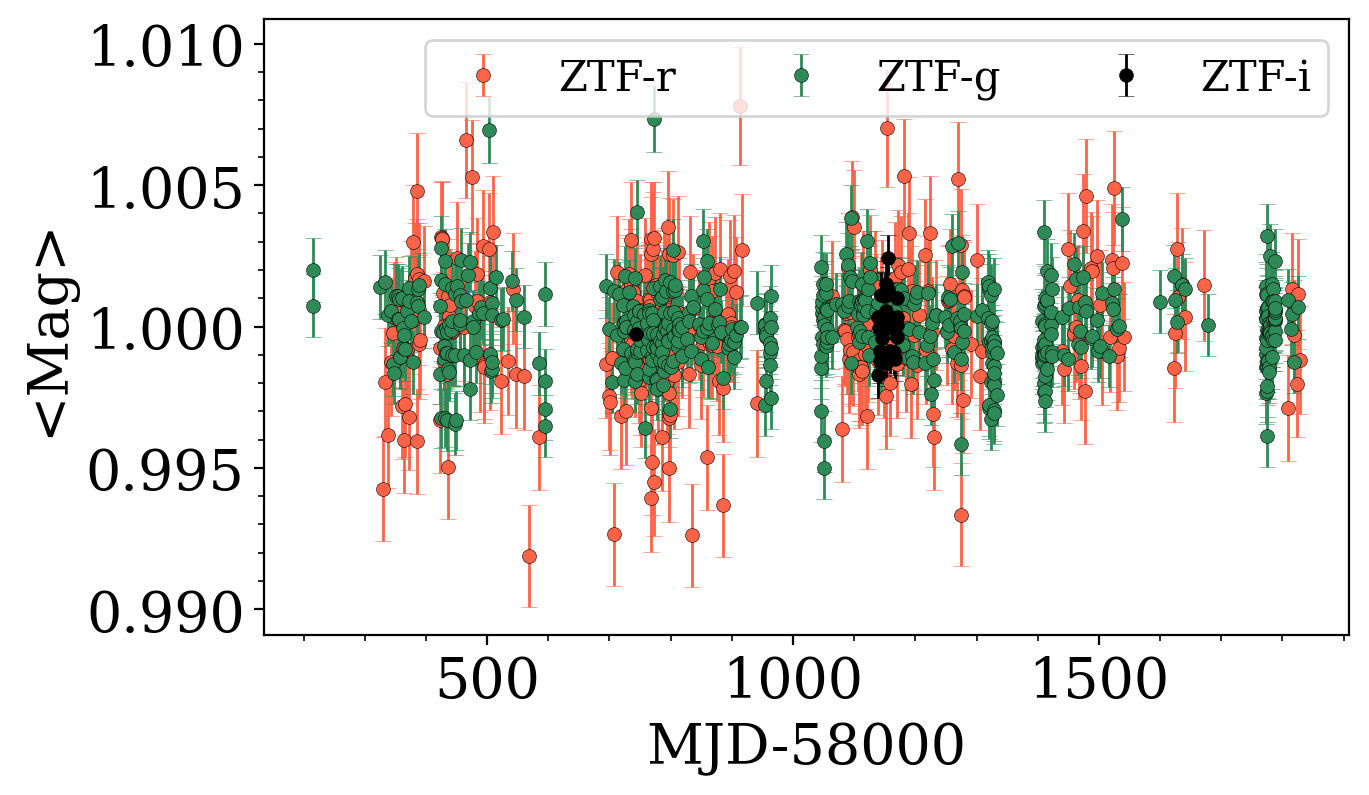

In [62]:
# gri light curves

flts = list('gri')
clrs = ['tomato', 'seagreen', 'k']
label=['ZTF-r', 'ZTF-g', 'ZTF-i']

plt.figure(figsize=(7, 4))
for a, b, c in zip(flts, clrs, label):

    time, mag, magerr = my_tools.prepare_lc(lc['mjd_ztf_source'],
                       lc['mag_ztf_source'], 
                       lc['magerr_ztf_source'], 
                       lc['catflags_ztf_source'],
                       lc['band_ztf_source'], band_of_study=a, flag_good=0)
    
    plt.errorbar(time-58_000, mag/np.median(mag), magerr/np.median(mag), fmt='.', color=b, mec='k', mew=0.2, lw=1, 
                label=c, ms=10, capsize=3)
    plt.minorticks_on()
    plt.xlabel("MJD-58000")
    plt.ylabel('<Mag>')

  
plt.legend(ncols=3, fontsize=15)

(17.09823477640748, 16.826288897544146)

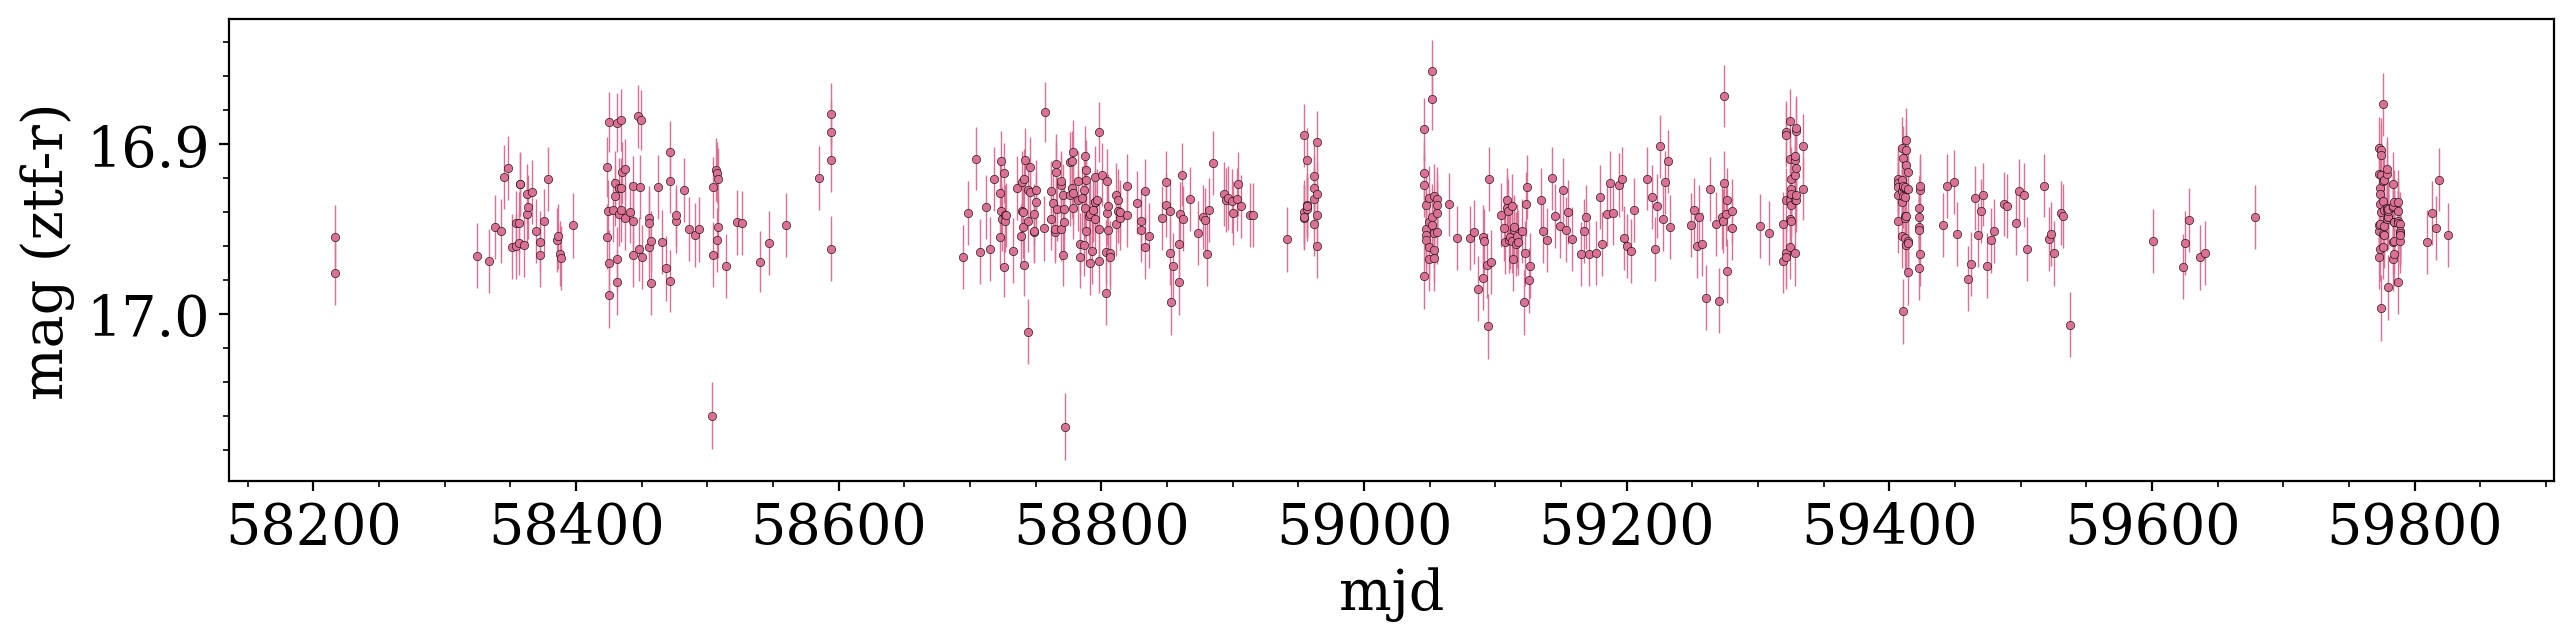

In [68]:
time, mag, magerr = my_tools.prepare_lc(lc['mjd_ztf_source'],
                   lc['mag_ztf_source'], 
                   lc['magerr_ztf_source'], 
                   lc['catflags_ztf_source'],
                   lc['band_ztf_source'], band_of_study='r', flag_good=0)

plt.figure(figsize=(15, 3))
plt.errorbar(time, mag, magerr, fmt='.', color='palevioletred', mec='k', mew=0.2, lw=0.5)
plt.minorticks_on()
plt.xlabel("mjd")
plt.ylabel('mag (ztf-r)')
plt.ylim(plt.ylim()[::-1])

In [76]:
time, mag, magerr = my_tools.fill_gaps(time, mag, magerr, num_points=25, max_gap_days=95)

<ErrorbarContainer object of 3 artists>

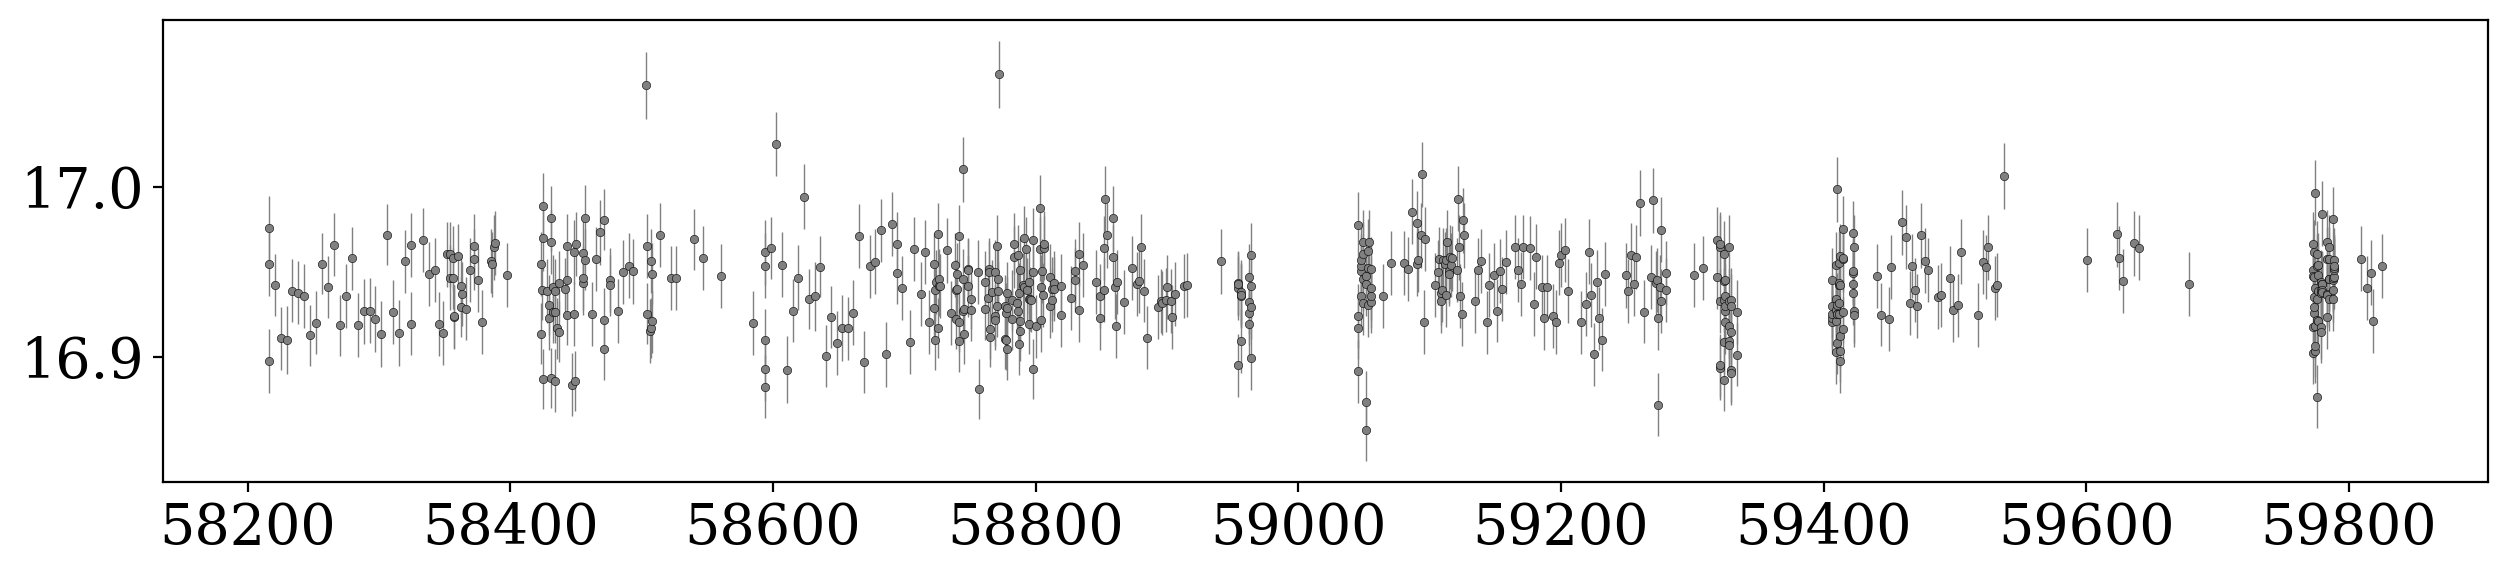

In [77]:
plt.figure(figsize=(15, 3))
plt.errorbar(time, mag, magerr, fmt='.', color='gray', mec='k', mew=0.2, lw=0.5)

In [78]:
# Evaluate biweight location and scale
R, S = astro_stats.biweight.biweight_location(mag), astro_stats.biweight.biweight_scale(mag)

# Running deviation
running_deviation = dip_pipeline.deviation(mag, magerr, R, S)

Text(0, 0.5, '(m-R)/($\\sigma^2$+S$^{2}$)$^{0.5}$')

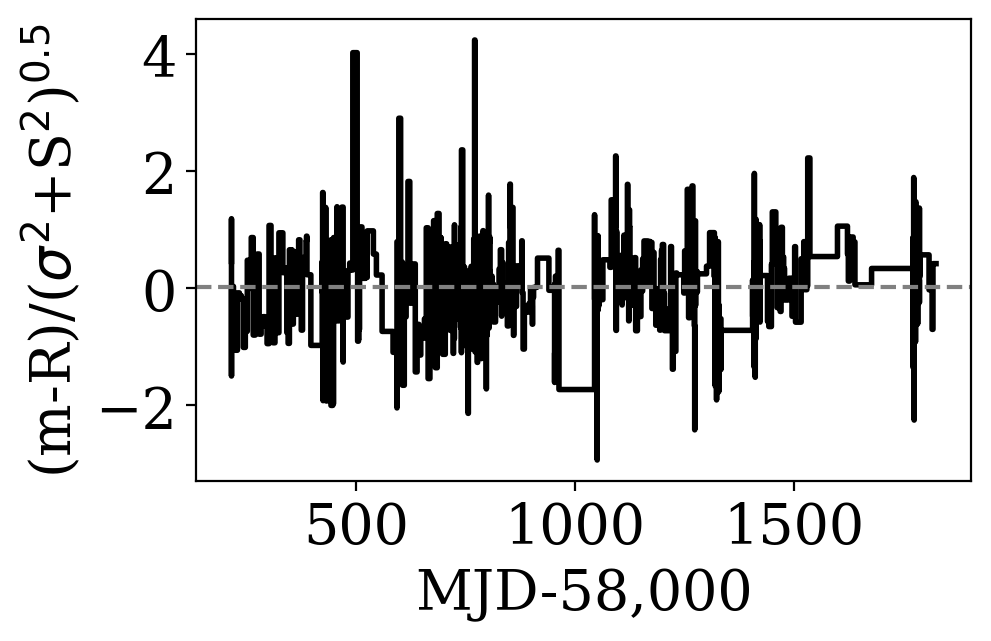

In [103]:
plt.figure(figsize=(5,3))
plt.step(time-58_000, running_deviation, color='k', lw=2)
plt.axhline(np.median(running_deviation), ls='--', color='gray')
plt.xlabel("MJD-58,000")
plt.ylabel("(m-R)/($\sigma^2$+S$^{2}$)$^{0.5}$")

In [2413]:
# Peak detection summary per light curve
peak_detections = dip_pipeline.peak_detector(time, running_deviation, power_thresh=3, peak_close_rmv=15, pk_2_pk_cut=30)

# Select best peak candidate with at least 3 points in the dip
bp = dip_pipeline.best_peak_detector(peak_detections, min_in_dip=5)

In [2414]:
bp

peak_loc            59748.075204
window_start        59818.445580
window_end          59629.165240
N_1sig_in_dip           5.000000
N_in_dip               35.000000
loc_forward_dur        70.370376
loc_backward_dur      118.909964
dip_power               5.000761
average_dt_dif          5.186605
Name: 0, dtype: float64

In [2415]:
x, y, yerr = my_tools.digest_the_peak(bp, time, mag, magerr, expandby=3)

Task exception was never retrieved
future: <Task finished name='Task-35811443' coro=<Client._gather.<locals>.wait() done, defined at /epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:2209> exception=AllExit()>
Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py", line 2218, in wait
    raise AllExit()
distributed.client.AllExit


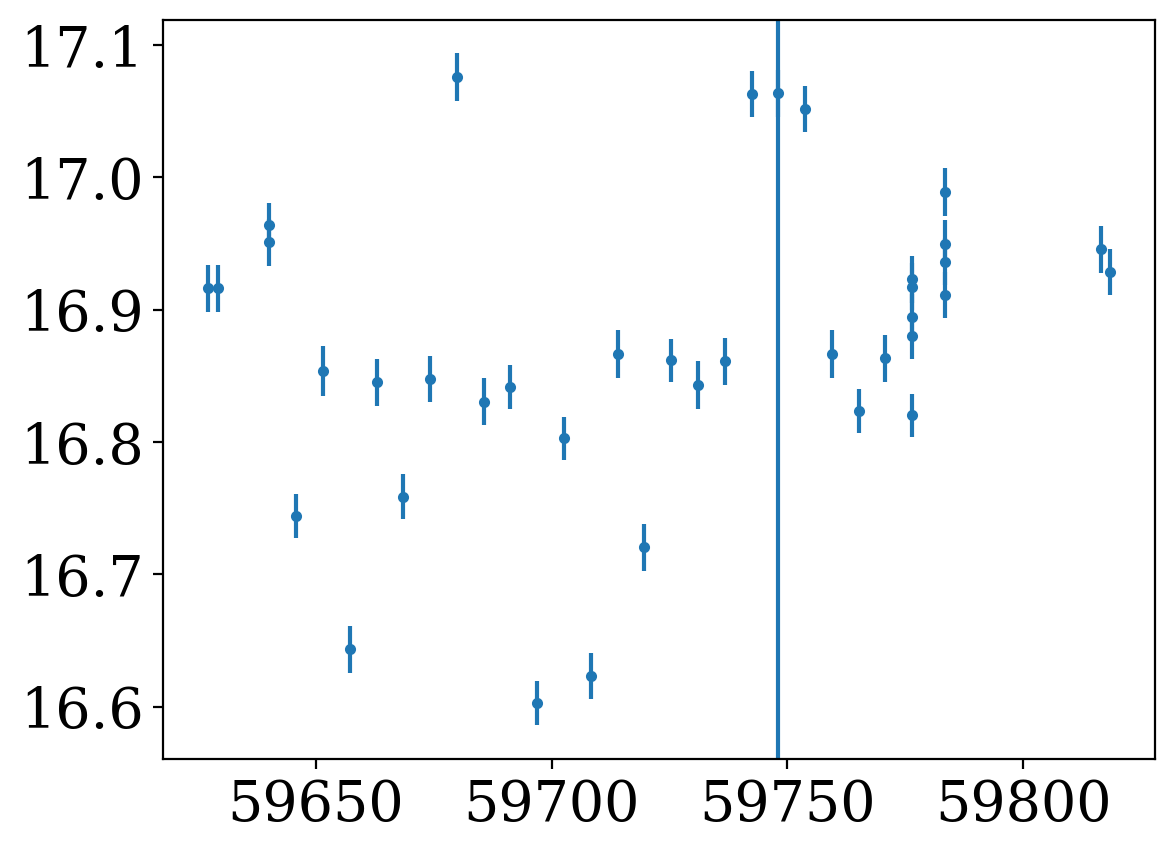

In [2416]:
plt.errorbar(x, y, yerr, fmt='.')
plt.axvline(bp['peak_loc'])

In [2418]:
astropy_fit = my_tools.quick_Gaussian_fit(time, running_deviation)

In [2419]:
astropy_fit

{'amplitude': 5.406676292419434,
 'mean': 59679.048955000166,
 'stddev': 0.9454512336747528}

(17.11910066809505, 16.5606508621946)

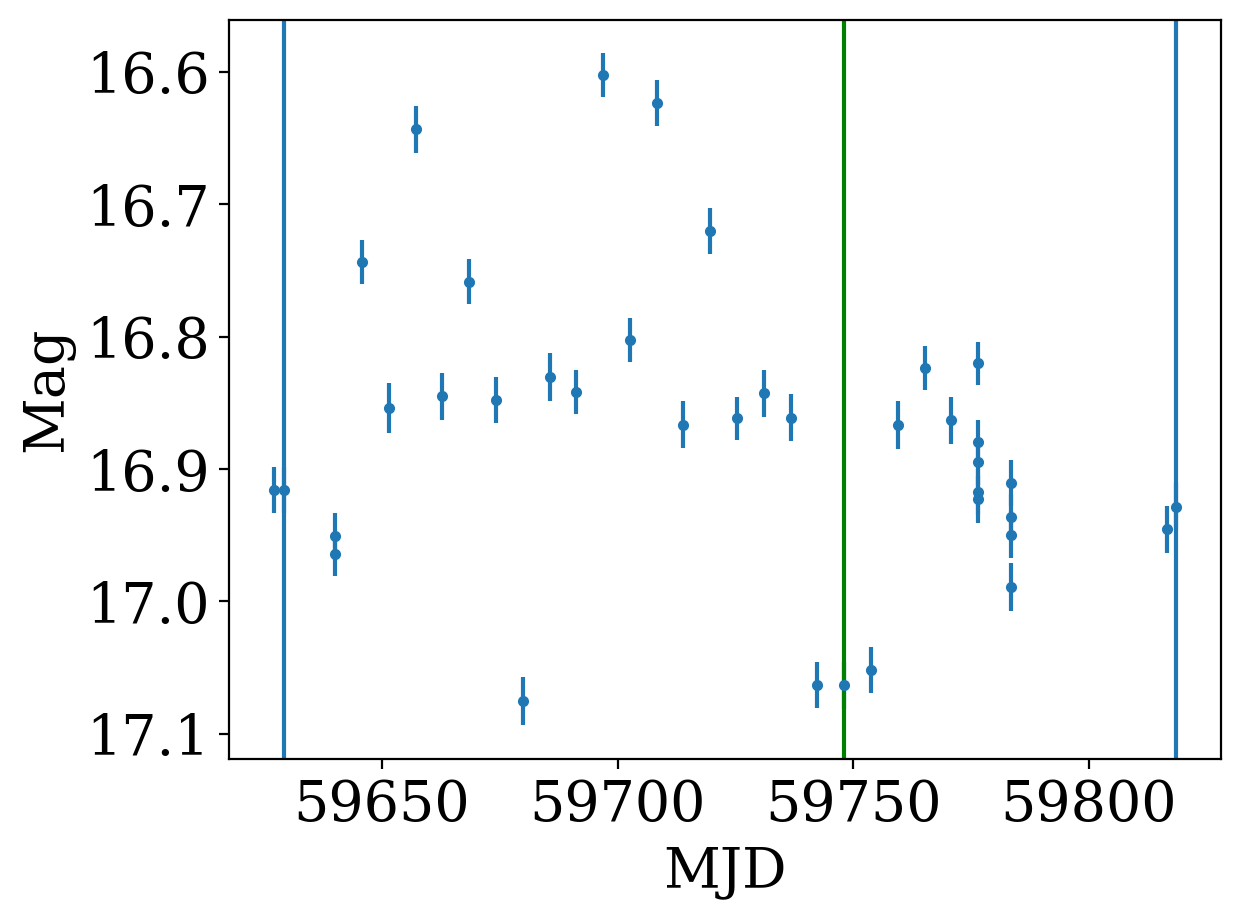

In [2420]:
plt.errorbar(x, y, yerr, fmt='.')
plt.axvline(bp['window_start'])
plt.axvline(bp['window_end'])
plt.xlabel("MJD")
plt.ylabel("Mag")
plt.axvline(bp['peak_loc'], color='green')
plt.ylim(plt.ylim()[::-1])

In [2421]:
init = dict(amp=astropy_fit['amplitude'],
            location=bp['peak_loc'],
            sigma=astropy_fit['stddev'], log_sigma2=np.log(0.4))

In [2422]:
%%time
gp2 = model_gp(x, y, yerr, bp['window_end'],
               bp['window_start'], init)

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/paper/../../dipper/gpmcmc.py:24: RuntimeWarning: overflow encountered in exp
  return self.amp * np.exp(-0.5*(t.flatten()-self.location)**2/(self.sigma**2) * np.exp(-self.log_sigma2))


CPU times: user 2min 7s, sys: 1min 50s, total: 3min 58s
Wall time: 2min 16s


In [2423]:
gp2

(array([59627.16634  , 59627.2046035, 59627.242867 , ..., 59818.369053 ,
        59818.4073165, 59818.44558  ]),
 array([16.91493175, 16.86794608, 16.86443779, ..., 16.86445854,
        16.86880262, 16.92698162]),
 array([0.0003004 , 0.01391268, 0.01398177, ..., 0.01398177, 0.0139127 ,
        0.00030312]),
 {'log-like': 35.286992185973176,
  'amp_median': 16.864350652860985,
  'amp_std': 0.025122779820596932,
  'location_median': 59729.93835492412,
  'location_std': 65.40186340319757,
  'sigma_median': 283.64477870679724,
  'sigma_std': 315.4261860558524,
  'log_sigma2_median': 827.3132698140071,
  'log_sigma2_std': 19272.14826065131,
  'm_median': -4.269997987604835,
  'm_std': 0.28224184478373754,
  'b_median': -8.351784272474825,
  'b_std': 156.96235587295325})

<ErrorbarContainer object of 3 artists>

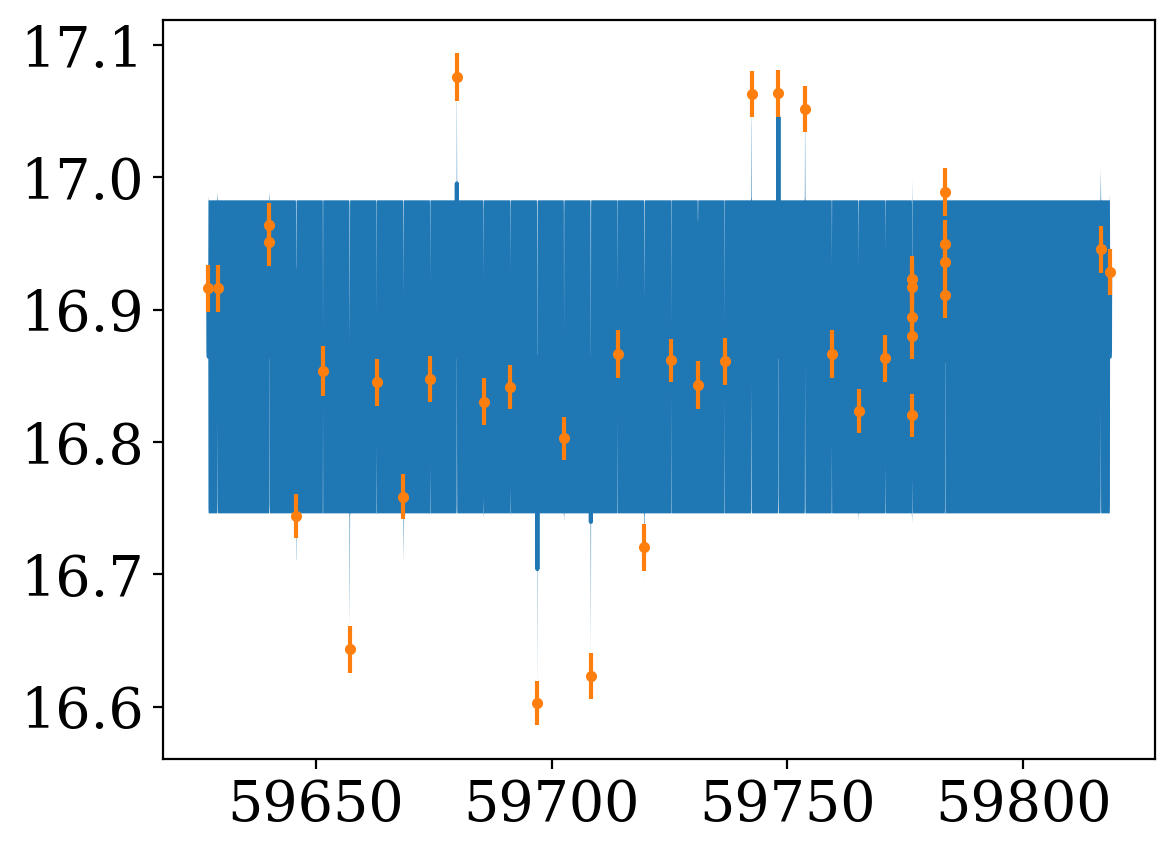

In [2424]:
plt.plot(gp2[0], gp2[1])
plt.fill_between(gp2[0], gp2[1]-np.sqrt(gp2[2]), gp2[1]+np.sqrt(gp2[2]))
plt.errorbar(x, y, yerr, fmt='.')

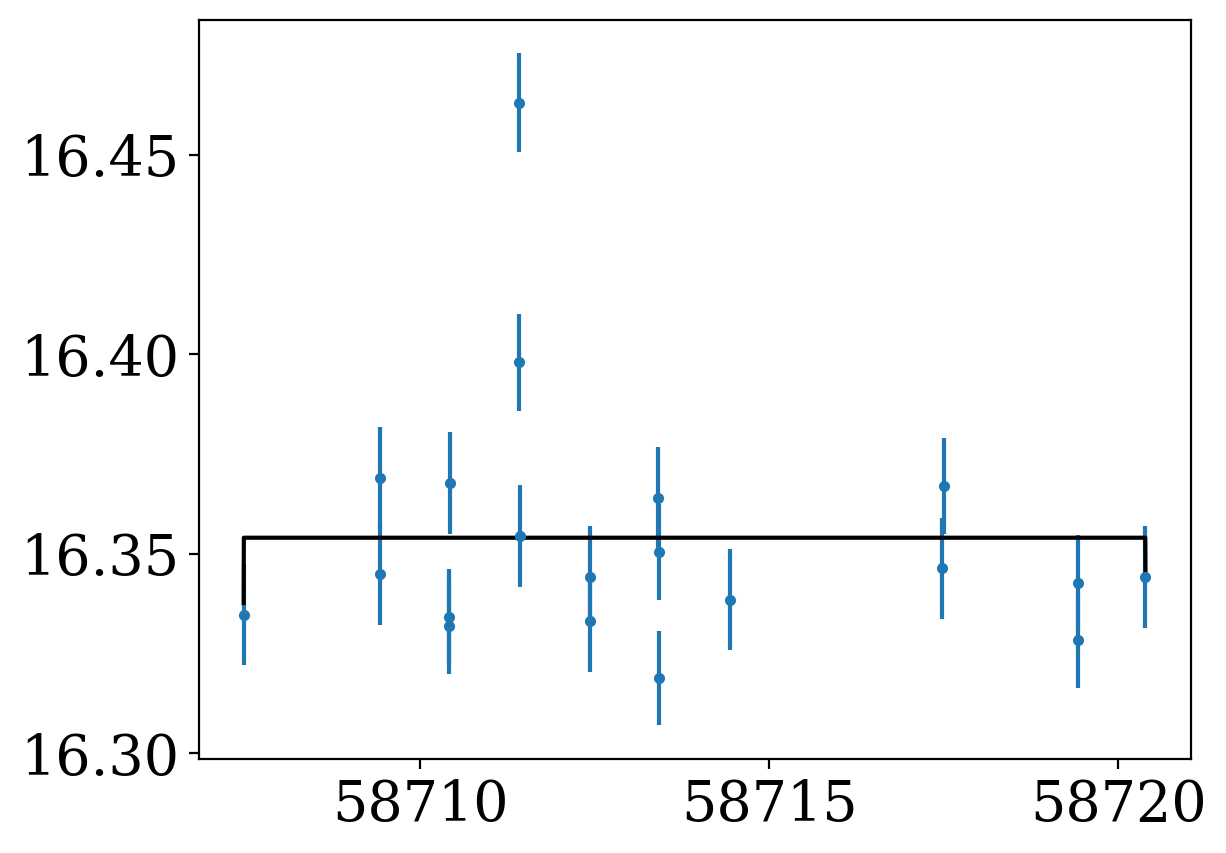

In [2307]:
plt.errorbar(x, y, yerr, fmt='.')
plt.plot(gp2[0], gp2[1], color='k')

In [2311]:
gp = dip_pipeline.GaussianProcess_dip(x, y, yerr, length_scale=0.01)

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


In [2312]:
gp[-1]

{'init_log_L': 0,
 'final_log_L': 0,
 'success_status': True,
 'chi-square': 103.30885881399318}

Text(0, 0.5, 'Mag')

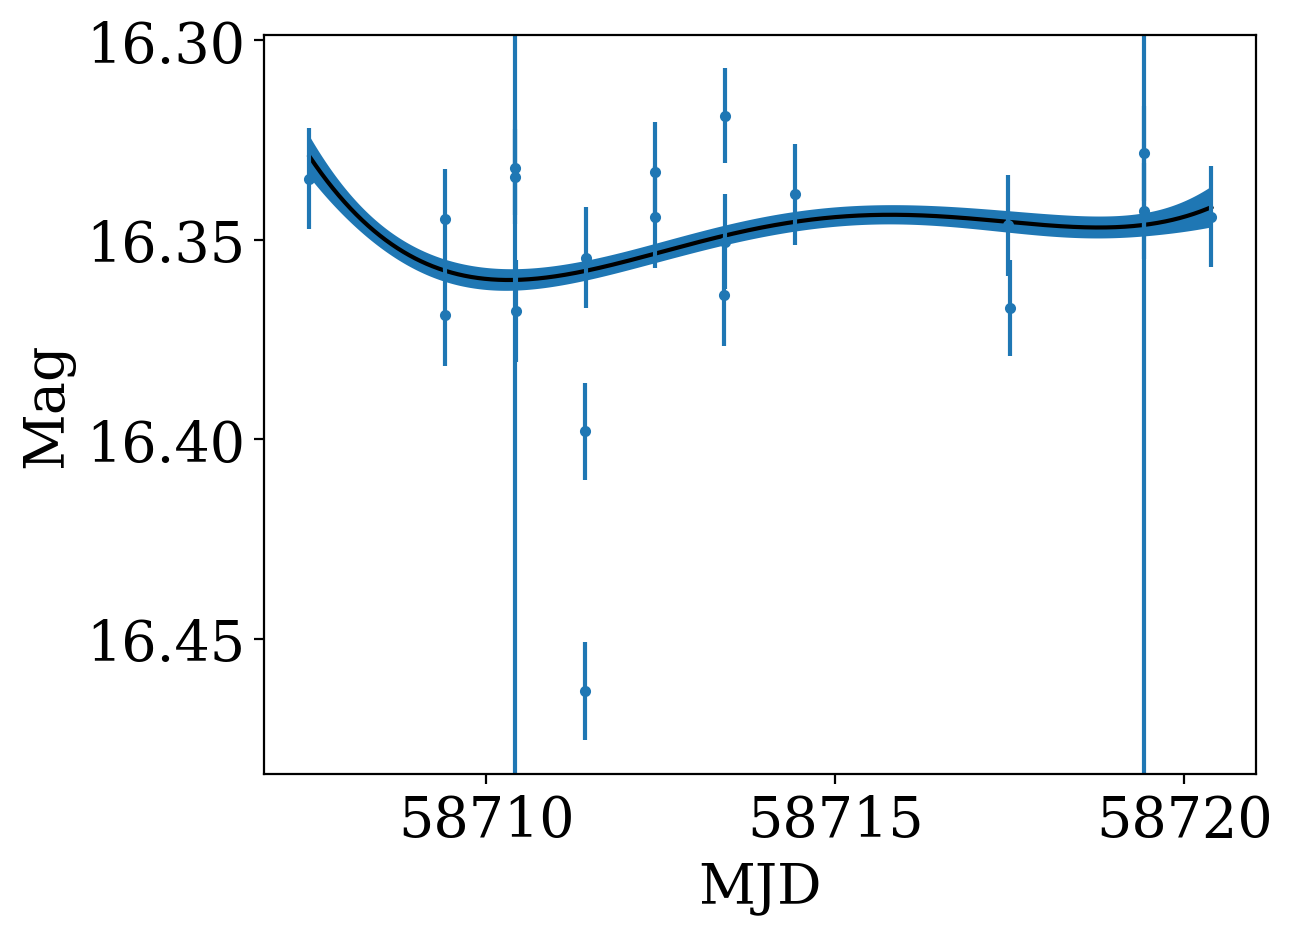

In [2313]:
plt.fill_between(gp[0], gp[1]-gp[2], gp[1]+gp[2])
plt.plot(gp[0], gp[1], color='k')
plt.errorbar(x, y, yerr, fmt='.')
plt.ylim(plt.ylim()[::-1])
plt.axvline(bp['window_start'])
plt.axvline(bp['window_end'])
plt.xlabel("MJD")
plt.ylabel("Mag")

In [944]:
variable_names = [
    'biweight_scale',
    'frac_above_2_sigma',
    'Ndips',
    'best_dip_power',
    'best_dip_time',
    'best_dip_start',
    'best_dip_end',
    'best_dip_dt',
    'best_dip_ndet',
    'best_dip_integral_score',
    'chi-square-gp',
    'closest_bright_star_arcsec',
    'closest_bright_star_mag',
    'closest_star_arcsec',
    'closest_star_mag',
    'density_arcsec2']


In [945]:
evaluate(lc['mjd_ztf_source'],
                   lc['mag_ztf_source'], 
                   lc['magerr_ztf_source'], 
                   lc['catflags_ztf_source'],
                   lc['band_ztf_source'], lc['ra_ztf_source']-180, lc['dec_ztf_source'], 
         gaia_lite, variable_names)

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


KeyboardInterrupt: 

## Synthetic Dip Example

In [2314]:
min(time), max(time)

(58288.46224, 59828.45702)

In [2315]:
time = np.linspace(58288.47665, 59829.44453, 250) + np.random.normal(2, 40000, 250)
time = time[np.argsort(time)]
model = dip_models.skew_norm(time, np.median(time)+330, 600, 0, 16, 0.5) + np.random.normal(0, 0.01, len(time))
model_err = np.random.normal(np.mean(magerr), np.std(magerr), 250)

<ErrorbarContainer object of 3 artists>

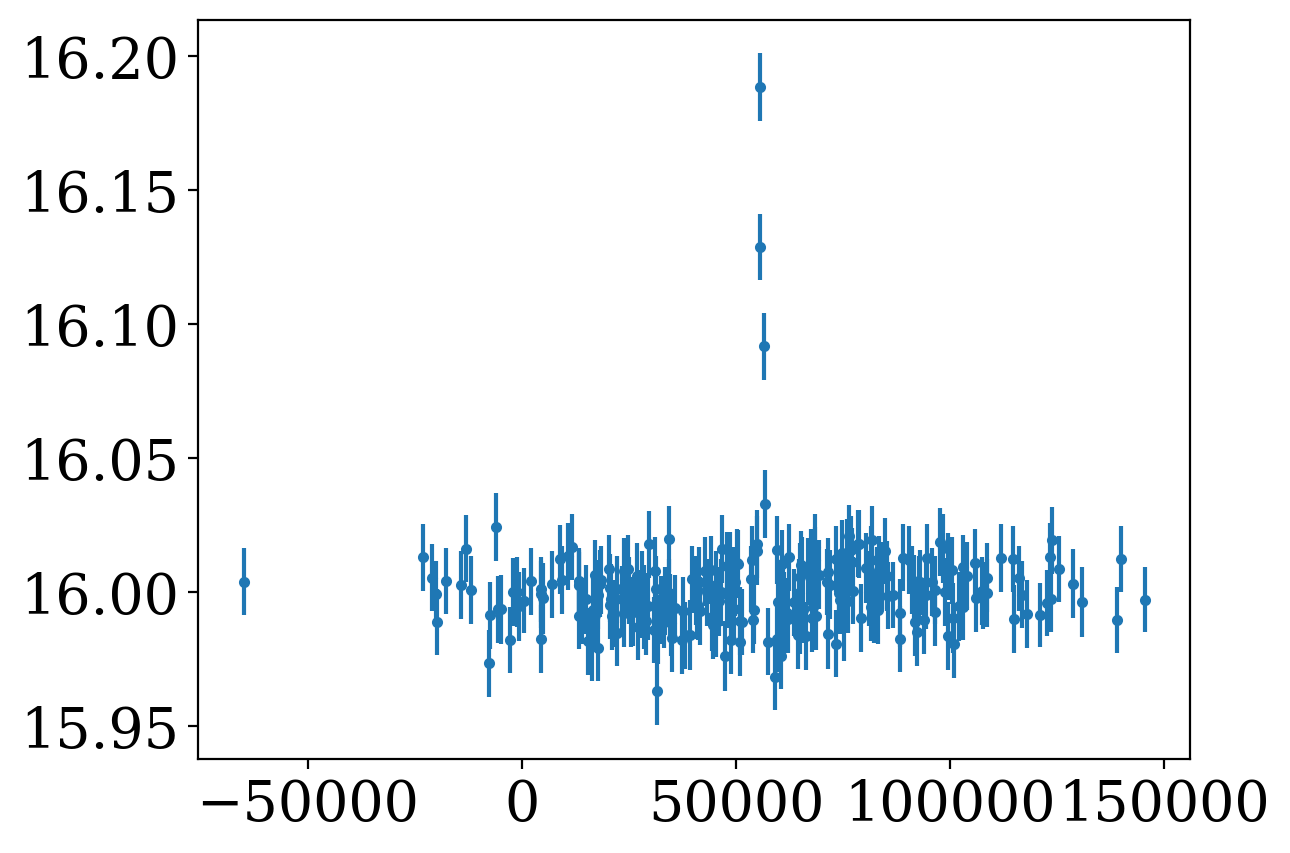

In [2316]:
plt.errorbar(time, model, model_err, fmt='.')

In [2317]:
# Evaluate biweight location and scale
R, S = astro_stats.biweight.biweight_location(model), astro_stats.biweight.biweight_scale(model)

# Running deviation
running_deviation = dip_pipeline.deviation(model, model_err, R, S)

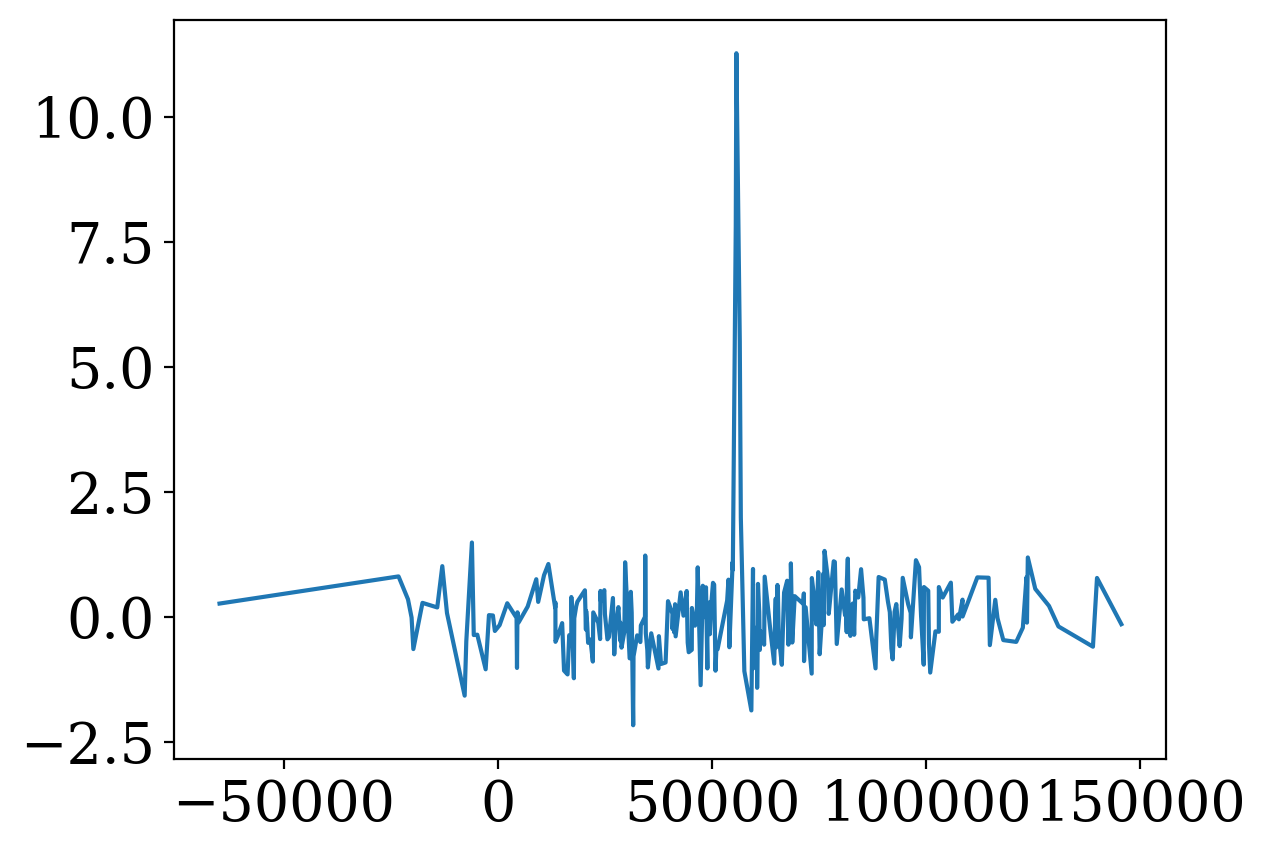

In [2318]:
plt.plot(time, running_deviation)

In [2319]:
t_init = models.Gaussian1D(amplitude=50., mean=time[np.argmax(running_deviation)]-1, stddev=0.2, 
                          bounds={"amplitude": (3, max(running_deviation)), 
                                 "mean": (time[np.argmax(running_deviation)]-535,
                                          time[np.argmax(running_deviation)]+535), 
                                 "stddev": (0.1, 1_000)})
fit_t = fitting.LevMarLSQFitter()
t = fit_t(t_init, time, running_deviation, maxiter=2_000)

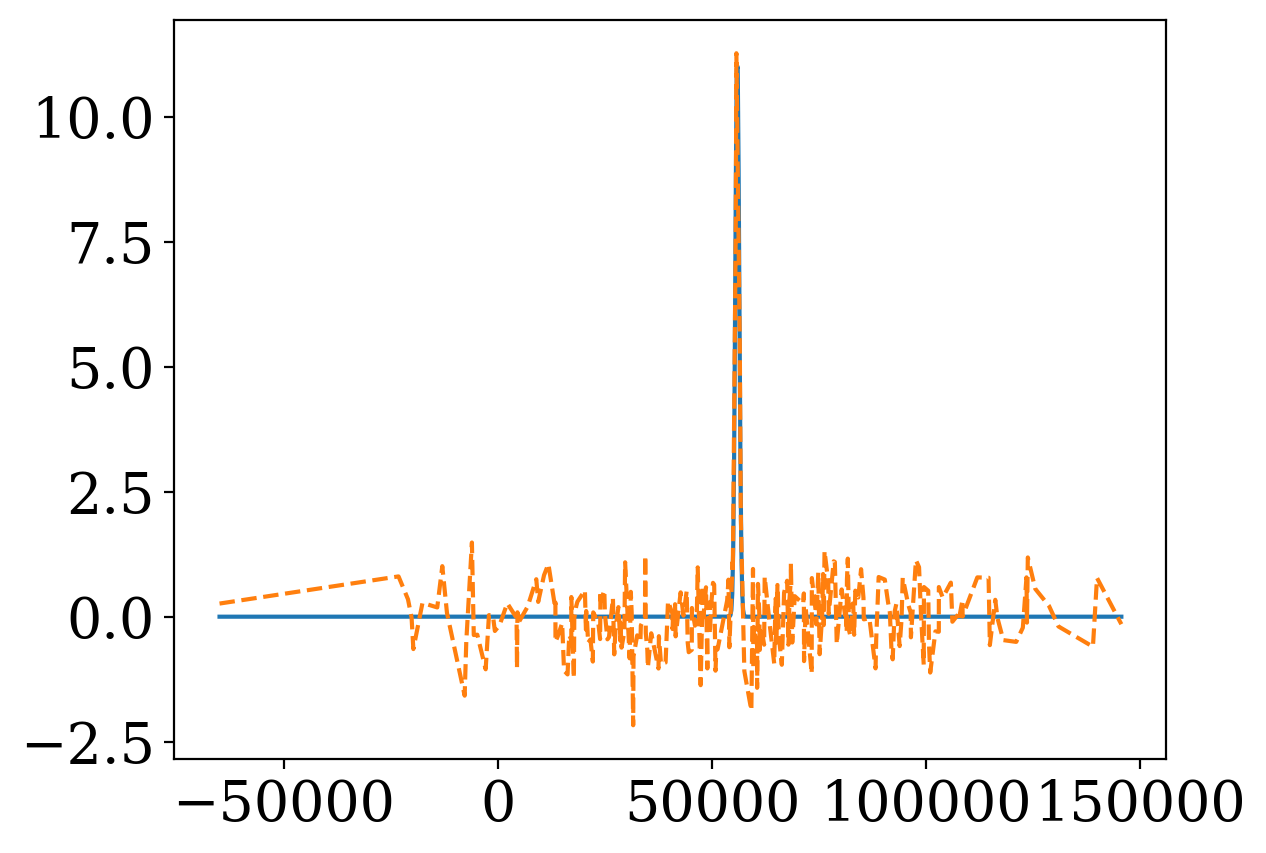

In [2320]:
bb = np.linspace(min(time), max(time), 1000)
plt.plot(bb, t(bb))
plt.plot(time, running_deviation, ls='--')

In [2321]:
peak_detections = dip_pipeline.peak_detector(time, running_deviation, power_thresh=3, peak_close_rmv=15, pk_2_pk_cut=30)

In [2322]:
peak_detections

(1,
 {'dip_0': {'peak_loc': 55675.248783692776,
   'window_start': 61225.98350846764,
   'window_end': 54842.99991123906,
   'N_1sig_in_dip': 4,
   'N_in_dip': 14,
   'loc_forward_dur': 5550.734724774862,
   'loc_backward_dur': 832.2488724537179,
   'dip_power': 11.270268585995659,
   'average_dt_dif': 431.9861505238889}})

In [2323]:
# Peak detection summary per light curve
peak_detections = dip_pipeline.peak_detector(time, running_deviation, power_thresh=3, peak_close_rmv=15, pk_2_pk_cut=30)


In [2324]:
peak_detections

(1,
 {'dip_0': {'peak_loc': 55675.248783692776,
   'window_start': 61225.98350846764,
   'window_end': 54842.99991123906,
   'N_1sig_in_dip': 4,
   'N_in_dip': 14,
   'loc_forward_dur': 5550.734724774862,
   'loc_backward_dur': 832.2488724537179,
   'dip_power': 11.270268585995659,
   'average_dt_dif': 431.9861505238889}})

In [2325]:
# Select best peak candidate with at least 3 points in the dip
bp = dip_pipeline.best_peak_detector(peak_detections, min_in_dip=3)

In [2340]:
x, y, yerr = my_tools.digest_the_peak(bp, time, model, model_err, expandby=3)

In [2341]:
astropy_fit = my_tools.quick_Gaussian_fit(time, running_deviation)

In [2342]:
%%time
init = dict(amp=t.amplitude.value,
            location=bp['peak_loc'],
            sigma=t.stddev.value, log_sigma2=np.log(0.4))
gp2 = model_gp(x, y, yerr, bp['window_end'].values[0], bp['window_start'].values[0], init, ell=1)

CPU times: user 25.6 s, sys: 5.2 s, total: 30.8 s
Wall time: 25.4 s


In [2344]:
gp2

(array([54842.99991124, 54844.27676333, 54845.55361542, ...,
        61223.42980429, 61224.70665638, 61225.98350847]),
 array([16.01664664, 16.01674969, 16.01685327, ..., 15.99263287,
        15.99262208, 15.99261152]),
 array([1.57929009e-04, 1.57695999e-04, 1.57530973e-04, ...,
        9.95644546e-05, 1.00955837e-04, 1.02385982e-04]),
 {'log-like': 29.525352374961326,
  'amp_median': 16.01588079018771,
  'amp_std': 0.5748082819373818,
  'location_median': 55777.91332932406,
  'location_std': 1670.97336626931,
  'sigma_median': 530.8951453788736,
  'sigma_std': 267.301879465984,
  'log_sigma2_median': 2356.364744541903,
  'log_sigma2_std': 195296.7652114766,
  'm_median': -5.061204790871286,
  'm_std': 2.0646563225580357,
  'b_median': 13.464353309584038,
  'b_std': 112.4984664783421})

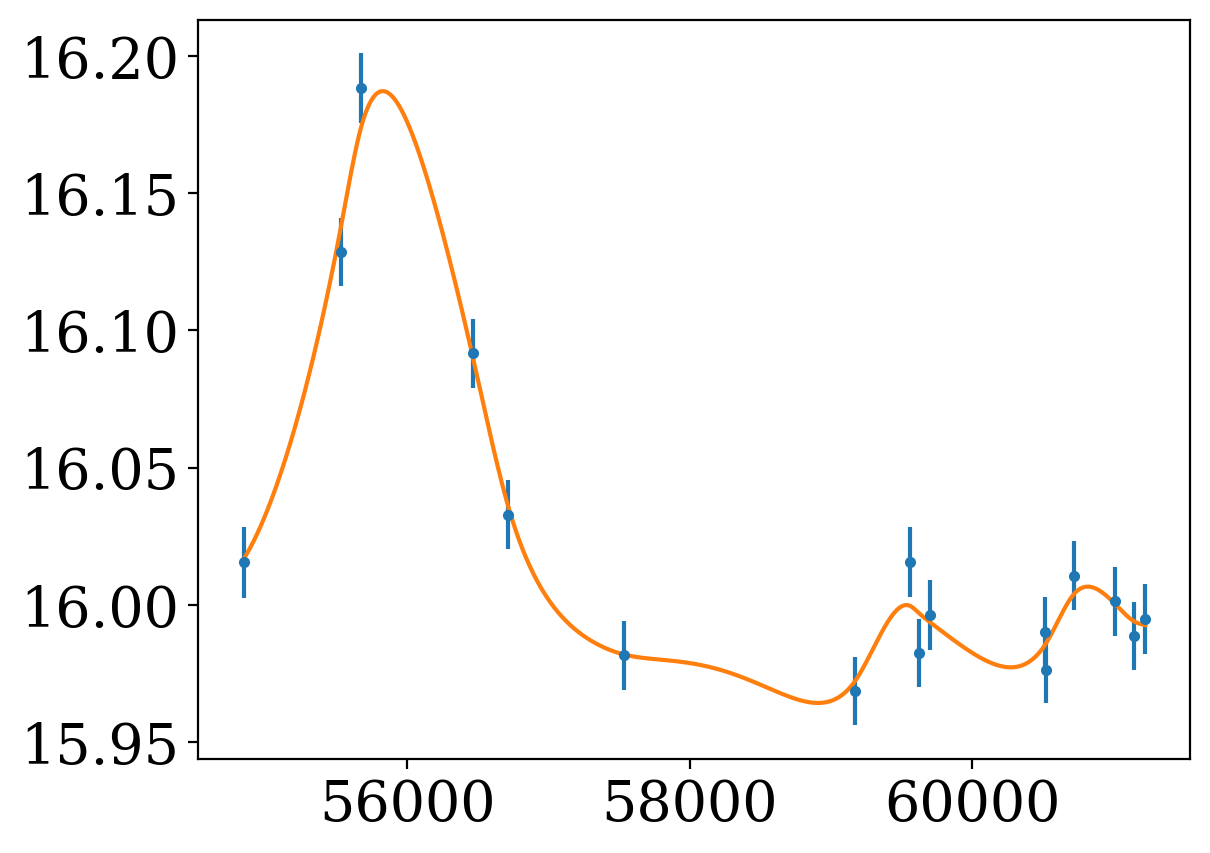

In [2343]:
plt.errorbar(x, y, yerr, fmt='.')
plt.plot(gp2[0], gp2[1])


In [990]:
a, b, c = np.percentile(y, [25, 50, 75])

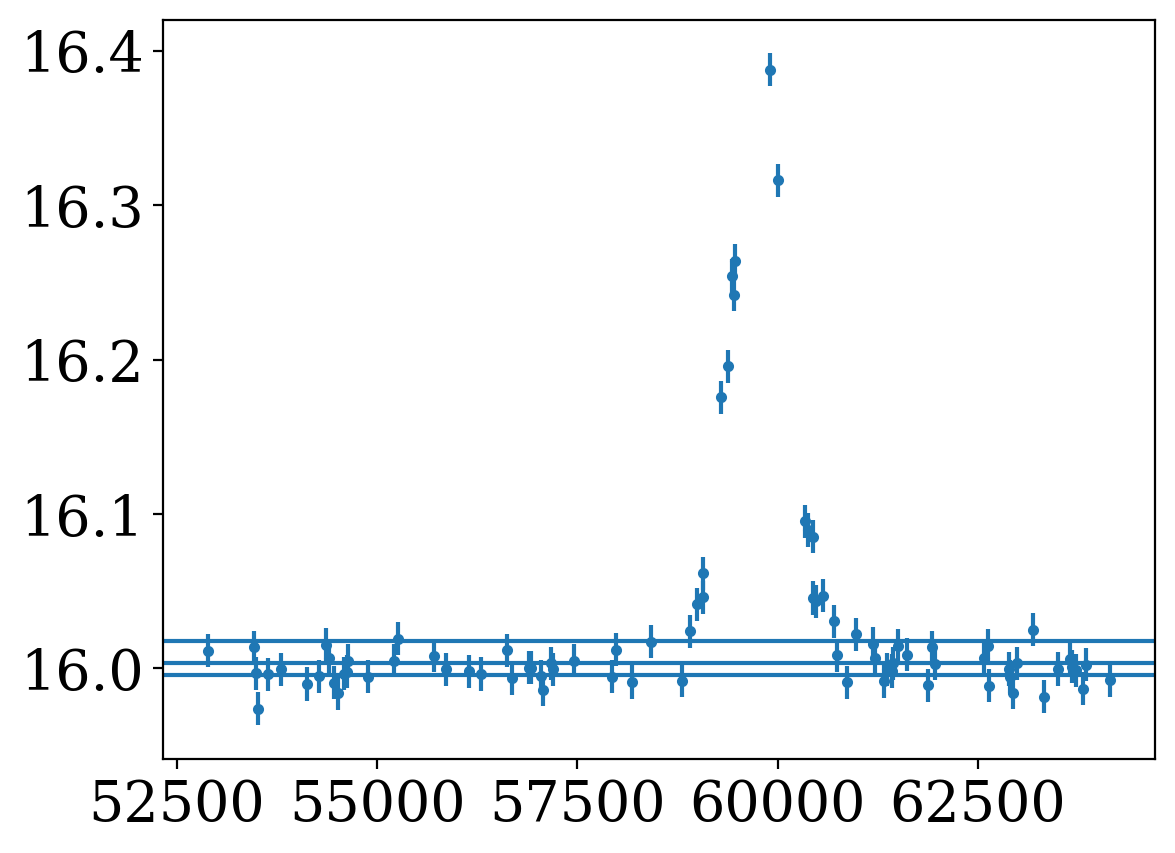

In [992]:
plt.errorbar(x, y, yerr, fmt='.')
plt.axhline(a)
plt.axhline(b)
plt.axhline(c)

In [993]:
gp = dip_pipeline.GaussianProcess_dip(x, y, yerr, length_scale=0.01)

In [994]:
gp

(array([52891.92248458, 52897.55429833, 52903.18611208, ...,
        64138.65454576, 64144.28635952, 64149.91817327]),
 array([16.01069938, 16.01083711, 16.01097392, ..., 15.99244211,
        15.99162674, 15.9907655 ]),
 array([0.00524242, 0.00496456, 0.00472623, ..., 0.00473491, 0.00497365,
        0.00525194]),
 {'init_log_L': 0,
  'final_log_L': 0,
  'success_status': True,
  'chi-square': 198.35117090023957})

<ErrorbarContainer object of 3 artists>

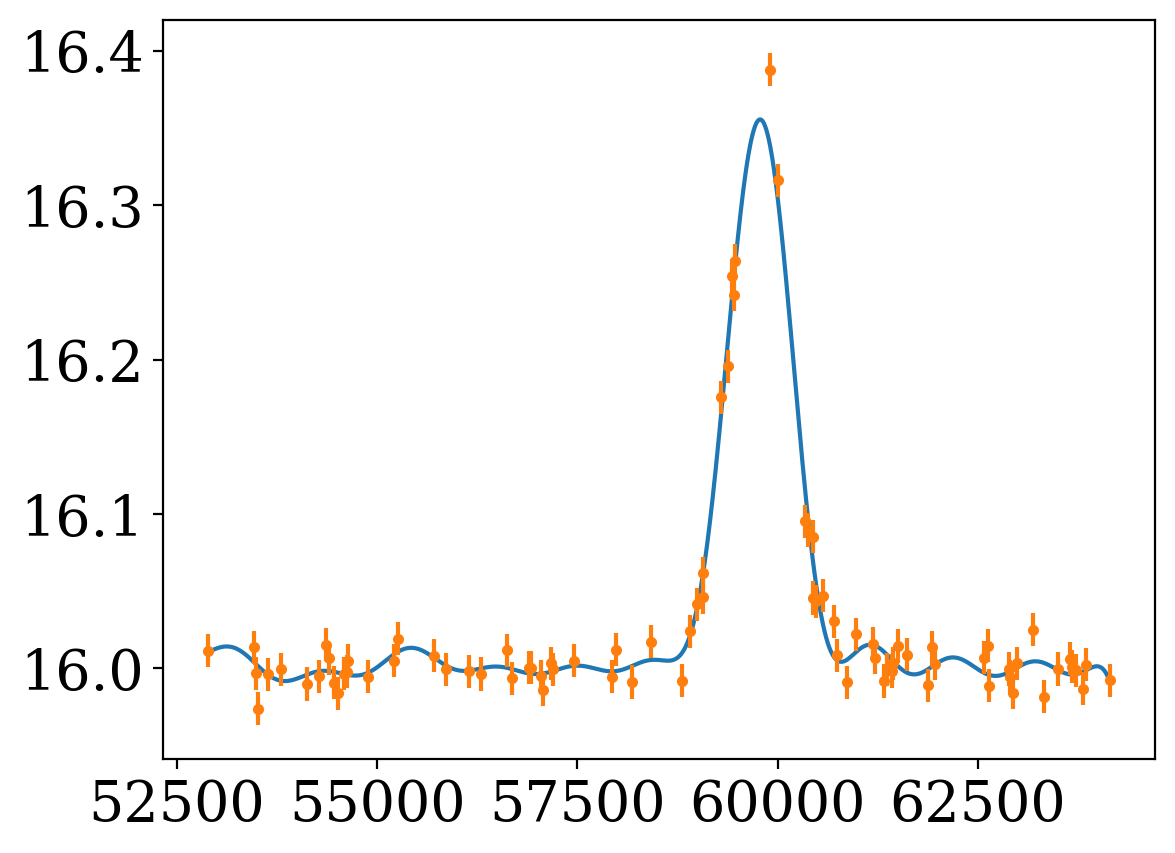

In [995]:
plt.plot(gp[0], gp[1])
plt.errorbar(x, y, yerr, fmt='.')

In [655]:
from tqdm import tqdm
for _id in tqdm(ens.object.head(50).index):
    lc = ens.source.loc[_id].compute()
    print (f'Now computing.... {_id}')
    result = evaluate(lc['mjd_ztf_source'],
                   lc['mag_ztf_source'], 
                   lc['magerr_ztf_source'], 
                   lc['catflags_ztf_source'],
                   lc['band_ztf_source'], lc['ra_ztf_source'], lc['dec_ztf_source'], 
         gaia_lite, None)

  0%|          | 0/50 [00:00<?, ?it/s]

Now computing.... 6124190825120268288


  2%|▏         | 1/50 [00:04<03:56,  4.83s/it]

No peaks found!


  4%|▍         | 2/50 [00:06<02:28,  3.09s/it]

Now computing.... 6124191013062836224
No dip is found within the minimum number of detections.
No peaks found!
Now computing.... 6124191246257750016


  6%|▌         | 3/50 [00:12<03:27,  4.41s/it]

Now computing.... 6124191326687723520


  8%|▊         | 4/50 [00:20<04:21,  5.69s/it]

Now computing.... 6124284960145670144


 10%|█         | 5/50 [00:30<05:34,  7.43s/it]

Now computing.... 6124285425998626816


 12%|█▏        | 6/50 [00:39<05:46,  7.87s/it]

No peaks found!
Now computing.... 6124285419317100544


 14%|█▍        | 7/50 [00:45<05:10,  7.23s/it]

Now computing.... 6124285541832720384


 16%|█▌        | 8/50 [00:51<04:50,  6.91s/it]

Now computing.... 6124285644991627264


 18%|█▊        | 9/50 [00:57<04:24,  6.45s/it]

Now computing.... 6124285923505995776


 20%|██        | 10/50 [01:03<04:20,  6.52s/it]

Now computing.... 6124286525535420416


 22%|██▏       | 11/50 [01:11<04:33,  7.01s/it]

Now computing.... 6124286607005581312


 24%|██▍       | 12/50 [01:18<04:22,  6.90s/it]

Now computing.... 6124286802434981888


 26%|██▌       | 13/50 [01:26<04:26,  7.19s/it]

Now computing.... 6124286935755128832


 28%|██▊       | 14/50 [01:34<04:25,  7.37s/it]

Now computing.... 6124287411426951168


 30%|███       | 15/50 [01:40<04:08,  7.10s/it]

Now computing.... 6124290044212543488


 32%|███▏      | 16/50 [01:53<04:56,  8.72s/it]

Now computing.... 6124290617573900288


 36%|███▌      | 18/50 [02:02<03:29,  6.56s/it]

Now computing.... 6124292181415952384
No dip is found within the minimum number of detections.
No peaks found!


 38%|███▊      | 19/50 [02:05<02:49,  5.48s/it]

Now computing.... 6124292340153581568
GP failed!
No peaks found!


 40%|████      | 20/50 [02:09<02:25,  4.86s/it]

Now computing.... 6124292744090222592
No dip is found within the minimum number of detections.
No peaks found!
Now computing.... 6124293136689659904


 42%|████▏     | 21/50 [02:16<02:44,  5.66s/it]

Now computing.... 6124293852284059648


 46%|████▌     | 23/50 [02:26<02:17,  5.10s/it]

Now computing.... 6124295724847857664
GP failed!
No peaks found!


 48%|████▊     | 24/50 [02:29<01:55,  4.43s/it]

Now computing.... 6124707728905469952
No dip is found within the minimum number of detections.
No peaks found!


 50%|█████     | 25/50 [02:32<01:40,  4.02s/it]

Now computing.... 6124708078114832384
GP failed!
No peaks found!


 52%|█████▏    | 26/50 [02:35<01:30,  3.76s/it]

Now computing.... 6124708528549527552
No dip is found within the minimum number of detections.
No peaks found!


 54%|█████▍    | 27/50 [02:38<01:25,  3.74s/it]

Now computing.... 6124709507495886848
No dip is found within the minimum number of detections.
No peaks found!


 56%|█████▌    | 28/50 [02:41<01:17,  3.52s/it]

Now computing.... 6124709476399316992
No dip is found within the minimum number of detections.
No peaks found!


 58%|█████▊    | 29/50 [02:44<01:10,  3.36s/it]

Now computing.... 6124709701872517120
No dip is found within the minimum number of detections.
No peaks found!


 60%|██████    | 30/50 [02:47<01:03,  3.20s/it]

Now computing.... 6124709843795181568
GP failed!
No peaks found!


 62%|██████▏   | 31/50 [02:50<00:58,  3.08s/it]

Now computing.... 6124712401217519616
No dip is found within the minimum number of detections.
No peaks found!


 64%|██████▍   | 32/50 [02:53<00:55,  3.07s/it]

Now computing.... 6124715116119195648
GP failed!
No peaks found!


 66%|██████▌   | 33/50 [02:56<00:51,  3.04s/it]

Now computing.... 6124716157652959232
No dip is found within the minimum number of detections.
No peaks found!


 68%|██████▊   | 34/50 [02:59<00:48,  3.02s/it]

Now computing.... 6124716768846938112
No dip is found within the minimum number of detections.
No peaks found!


 70%|███████   | 35/50 [03:02<00:43,  2.92s/it]

Now computing.... 6124717096719876096
GP failed!
No peaks found!


 72%|███████▏  | 36/50 [03:05<00:40,  2.91s/it]

Now computing.... 6124718374648807424
No dip is found within the minimum number of detections.
No peaks found!


 74%|███████▍  | 37/50 [03:08<00:38,  2.98s/it]

Now computing.... 6124718685740335104
GP failed!
No peaks found!


 76%|███████▌  | 38/50 [03:10<00:34,  2.89s/it]

Now computing.... 6124719155087147008
No dip is found within the minimum number of detections.
No peaks found!


 78%|███████▊  | 39/50 [03:13<00:31,  2.83s/it]

Now computing.... 6124719372763136000
No dip is found within the minimum number of detections.
No peaks found!


 80%|████████  | 40/50 [03:17<00:30,  3.10s/it]

Now computing.... 6124719522814361600
No dip is found within the minimum number of detections.
No peaks found!


 82%|████████▏ | 41/50 [03:20<00:27,  3.11s/it]

Now computing.... 6124738501628919808
No dip is found within the minimum number of detections.
No peaks found!


 84%|████████▍ | 42/50 [03:23<00:25,  3.13s/it]

Now computing.... 6124739361608040448
No dip is found within the minimum number of detections.
No peaks found!


 86%|████████▌ | 43/50 [03:26<00:21,  3.13s/it]

Now computing.... 6124740976058564608
No dip is found within the minimum number of detections.
No peaks found!


 88%|████████▊ | 44/50 [03:29<00:18,  3.03s/it]

Now computing.... 6124742375249018880
No dip is found within the minimum number of detections.
No peaks found!


 90%|█████████ | 45/50 [03:33<00:15,  3.13s/it]

Now computing.... 6124742738660294656
No dip is found within the minimum number of detections.
No peaks found!


 92%|█████████▏| 46/50 [03:35<00:12,  3.09s/it]

Now computing.... 6124743056034889728
No dip is found within the minimum number of detections.
No peaks found!


 94%|█████████▍| 47/50 [03:39<00:09,  3.09s/it]

Now computing.... 6124743478350970880
GP failed!
No peaks found!


 96%|█████████▌| 48/50 [03:41<00:05,  2.99s/it]

Now computing.... 6124743942748504064
No dip is found within the minimum number of detections.
No peaks found!


 98%|█████████▊| 49/50 [03:45<00:03,  3.07s/it]

Now computing.... 6124744188283060224
GP failed!
No peaks found!


100%|██████████| 50/50 [03:47<00:00,  4.56s/it]

Now computing.... 6124745004846940160
GP failed!
No peaks found!


In [66]:
import matplotlib.pyplot 

In [67]:
cm = matplotlib.pyplot.get_cmap('RdBu')

In [104]:
xx = np.linspace(-10, 10, 100) + np.random.normal(0, 1, 100)
yy = dip_models.skew_norm(xx, 0, 2, 0, 16, 0.1) + np.random.normal(0, 0.001, 100)

In [148]:
scr = []
from tqdm import tqdm
for j in tqdm(np.linspace(-5, 5, 30)):
    xx = np.linspace(-10, 10, 100) + np.random.normal(0, 1, 100)
    yy = dip_models.skew_norm(xx, 0, 2, j, 16, 0.1) + np.random.normal(0, 1e-12, 100)

    gp = dip_pipeline.GaussianProcess_dip(xx, yy, abs(np.random.normal(0, 1e-8, len(xx))), alpha=1, metric=100)

    # GP assesment of quality 
    gp_quality = dip_pipeline.evaluate_dip(gp, xx, yy, abs(np.random.normal(0, 1e-8, len(xx))), 
                                           np.median(yy), np.std(yy), 0, diagnostic=False)

    scr.append(gp_quality['assymetry_score'])

100%|██████████| 30/30 [00:12<00:00,  2.47it/s]


In [166]:
sk = np.linspace(-3, 3, 10)
sig = np.linspace(0.1, 5, 10)

xx = np.linspace(-15, 15, 50) + np.random.normal(0, 1, 50)
nz = abs(np.random.normal(0, 1e-8, len(xx)))

X, Y = np.meshgrid(sk, sig, indexing='xy')

Master = np.zeros(shape=np.shape(X))

for i in tqdm(range(len(X))):
    for j in range(len(Y)):
        yy = dip_models.skew_norm(xx, 0, sig[j], sk[i], 16, 0.1) 
        gp = dip_pipeline.GaussianProcess_dip(xx, yy, nz, alpha=1, metric=100)

        # GP assesment of quality 
        gp_quality = dip_pipeline.evaluate_dip(gp, xx, yy, nz, 
                                           np.median(yy), np.std(yy), 0, diagnostic=False)
        
        Master[i,j] = gp_quality['assymetry_score']
        
        

100%|██████████| 10/10 [00:18<00:00,  1.90s/it]


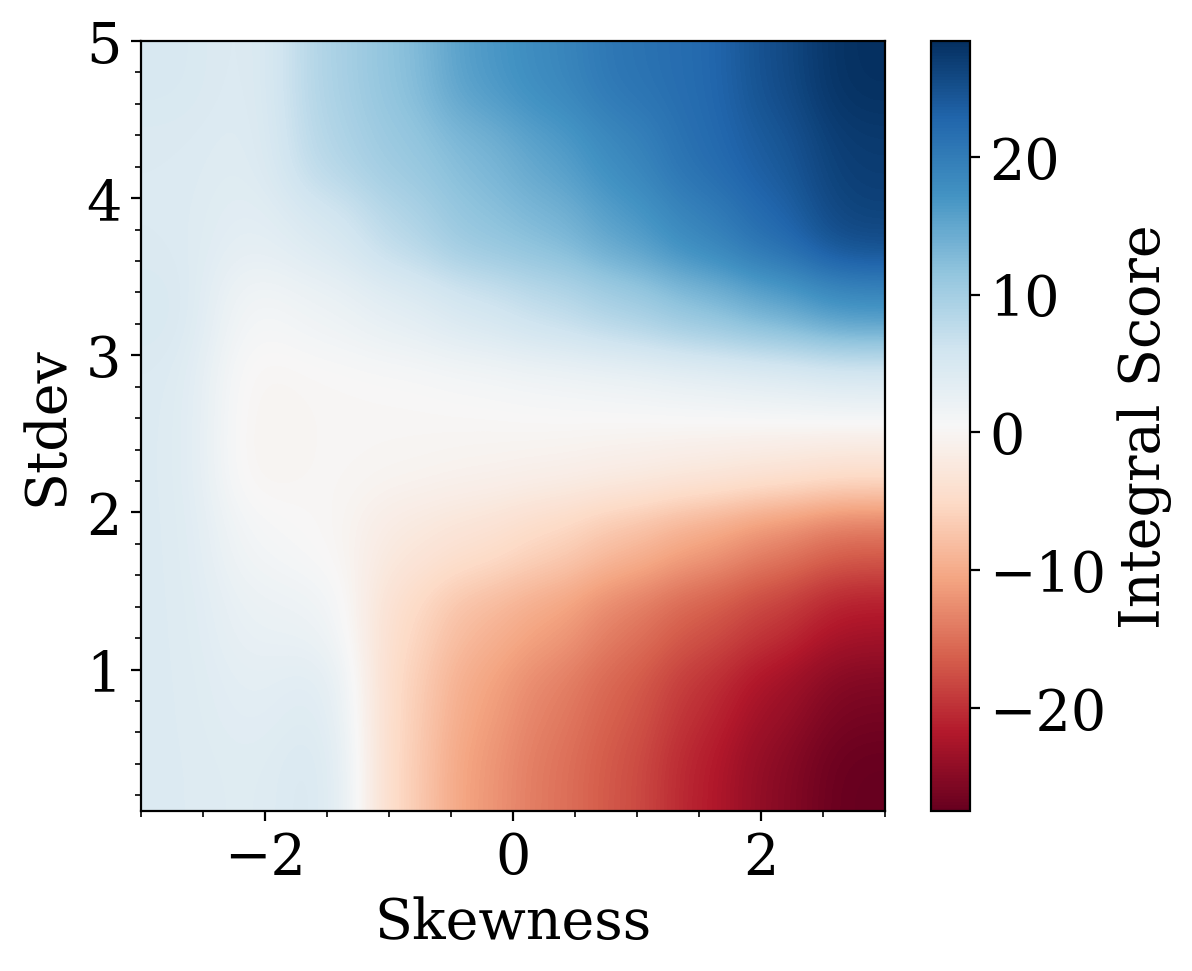

In [200]:
plt.figure(figsize=(6,5))
plt.imshow((Master), cmap='RdBu', extent=[np.min(X), np.max(X), np.min(Y), np.max(Y)], aspect='auto', 
          interpolation='Gaussian')
plt.colorbar(label='Integral Score')
plt.xlabel("Skewness")
plt.ylabel("Stdev")
plt.minorticks_on()

Text(-0.9, 16.01, 'Skew<0')

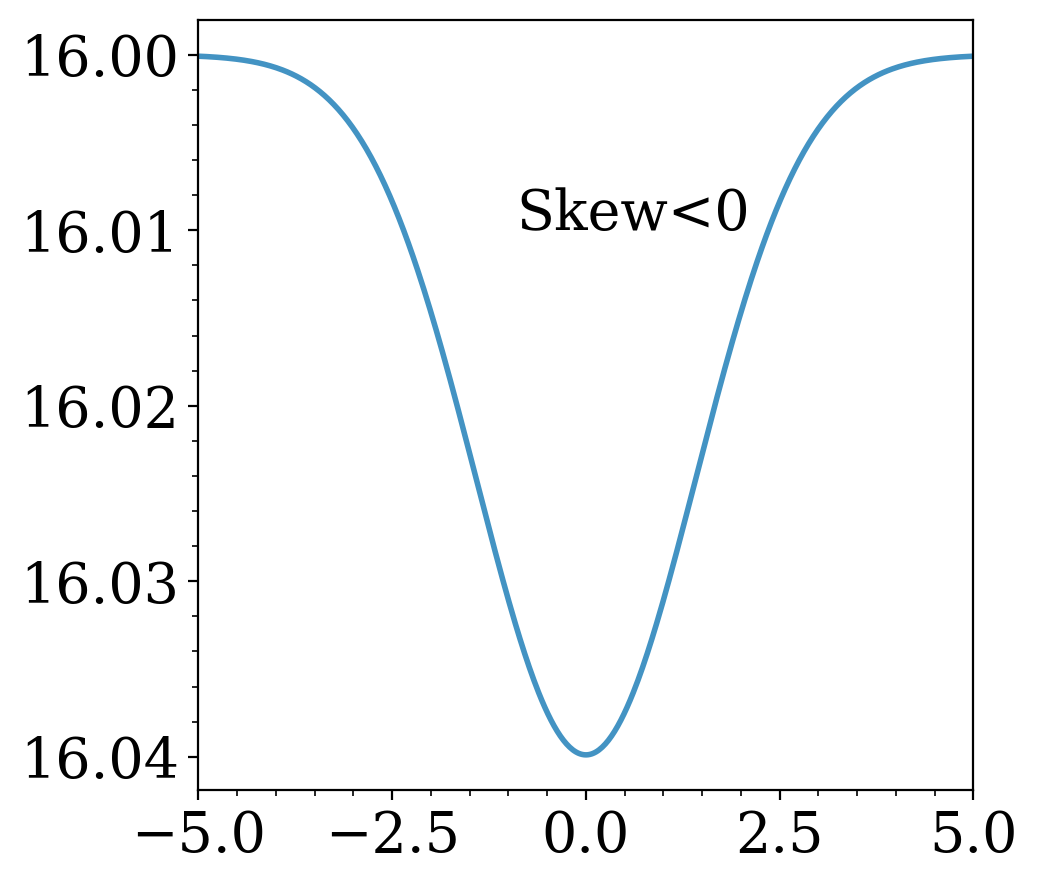

In [86]:
xx = np.linspace(-10, 10, 1000)
yy = dip_models.skew_norm(xx, 0, 2, 0, 16, 0.1)

plt.figure(figsize=(5,5))
plt.plot(xx, yy, color=cm(0.8), lw=2)
plt.ylim(plt.ylim()[::-1])
plt.minorticks_on()
plt.xlim(-5, 5)
plt.text(-0.9, 16.01, "Skew<0")

Text(0.5, 0, 'Phase')

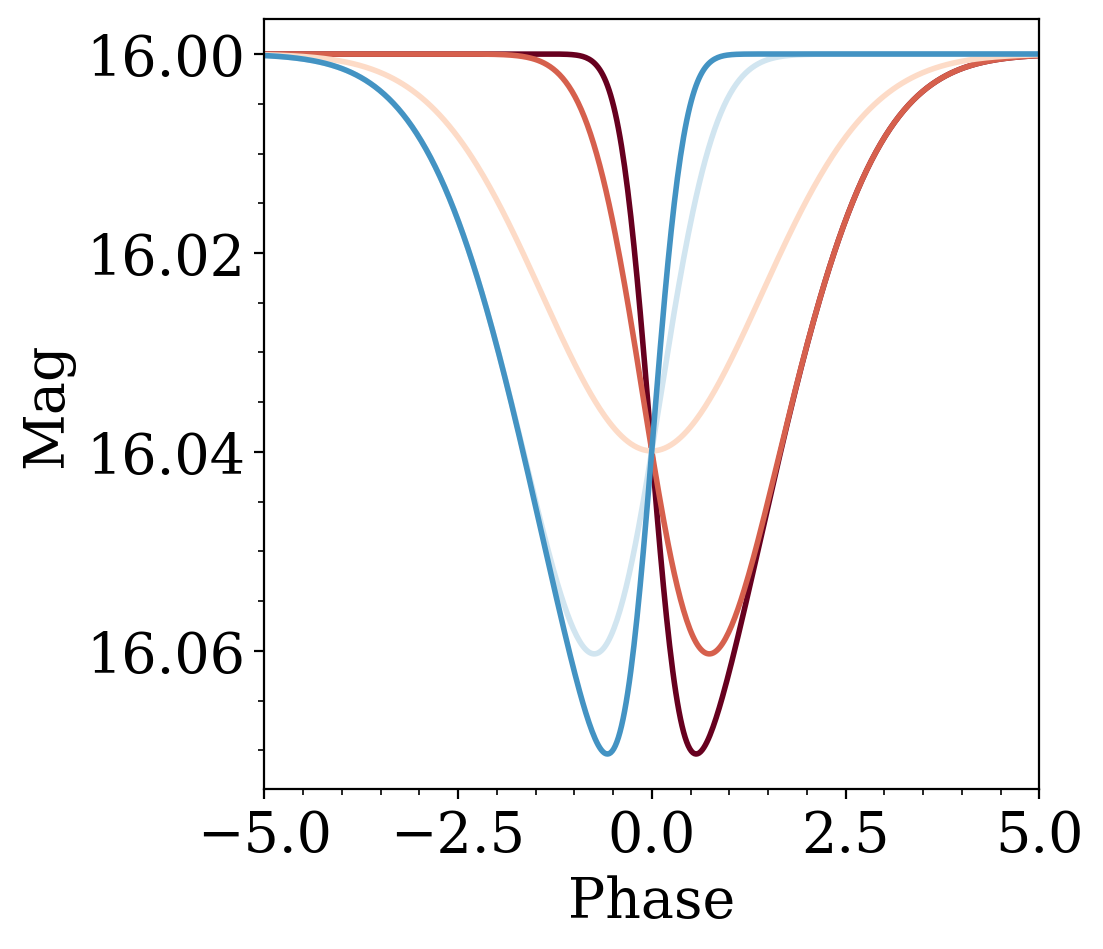

In [960]:
# fun plot 
xx = np.linspace(-10, 10, 1000)
ce = 0
plt.figure(figsize=(5,5))
for i in np.linspace(-3, 3, 5)[::-1]:
    yy = dip_models.skew_norm(xx, 0, 2, i, 16, 0.1)
    plt.plot(xx, yy, color=cm(ce), lw=2)
    ce += 0.2
plt.ylim(plt.ylim()[::-1])
plt.minorticks_on()
plt.xlim(-5, 5)
plt.ylabel("Mag")
plt.xlabel("Phase")

## Synthetic Observations

In [32]:
model = dip_models.skew_norm(time, np.median(time)+320, 15, -3, 16, 1) + np.random.normal(0, 0.001, len(time))
model_err = magerr

In [43]:
scr = []
for i in np.arange(-3, 3, step=0.25):
    model = dip_models.skew_norm(time, 
                                 np.median(time)+340,
                                 25, i, 16, 0.15) #
    model_err = 0.2*magerr

    tb = pd.DataFrame([],columns=('mjd', 'mag', 'magerr', 'flag', 'band'))

    tb['mjd'] = time
    tb['mag'] = model
    tb['magerr'] = model_err
    tb['flag'] = np.zeros(len(time))
    tb['band'] = ['r' for _ in range(len(time))]

    final = evaluate(tb['mjd'], tb['mag'], tb['magerr'], tb['flag'], tb['band'], 
            np.array([121, 123]), np.array([31, 31.3]), gaia_lite, None)
    scr.append(final.iloc[9])

{'assymetry_score': 395.7795107266872, 'left_error': 0.00310263094532, 'right_error': 3.403115186134597e-05, 'log_sum_error': 8.570701347318654, 'chi-square': 0.14145266244788846}
{'assymetry_score': 396.41217107264123, 'left_error': 0.0030961067331942865, 'right_error': 3.3342907686605207e-05, 'log_sum_error': 8.57516523621365, 'chi-square': 0.14273033028965024}
{'assymetry_score': 397.44739470655435, 'left_error': 0.003085413063639003, 'right_error': 3.2221921097405836e-05, 'log_sum_error': 8.582596406778807, 'chi-square': 0.14489467798425834}
{'assymetry_score': 399.04444252223544, 'left_error': 0.003068836627361609, 'right_error': 3.0499314568428076e-05, 'log_sum_error': 8.594433255042619, 'chi-square': 0.14844028107784654}
{'assymetry_score': 401.35161589820297, 'left_error': 0.0030446331743205443, 'right_error': 2.8015448754791575e-05, 'log_sum_error': 8.61250279701714, 'chi-square': 0.15409372610006128}
{'assymetry_score': 404.4380390497225, 'left_error': 0.0030114880357163024, 

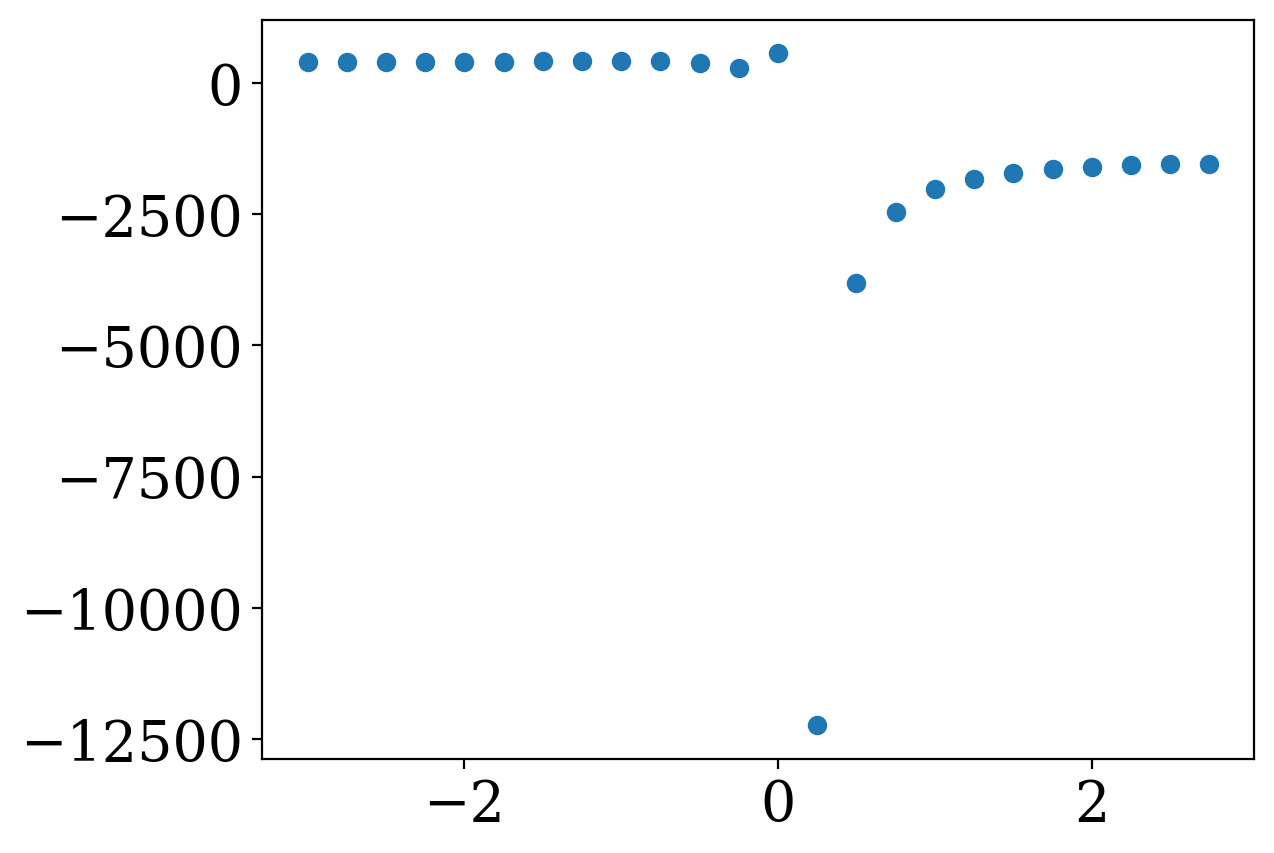

In [46]:
plt.scatter(np.arange(-3, 3, step=0.25), np.array(scr))

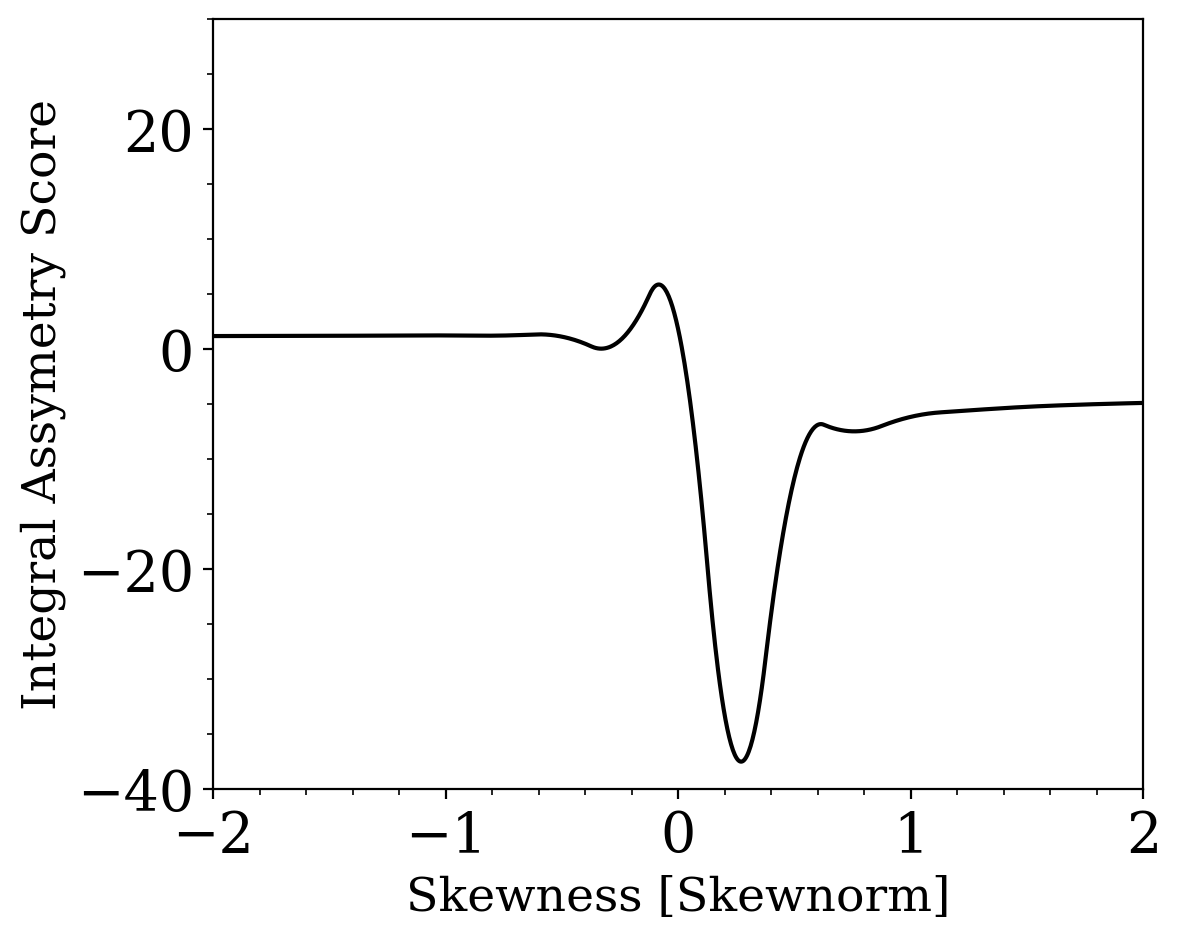

In [64]:
from scipy.interpolate import interp1d

plt.figure(figsize=(6,5))
f = interp1d(np.arange(-3, 3, step=0.25), (np.array(scr))/np.median(scr), kind='quadratic')
x1 = np.linspace(-2, 2, 1000)

plt.plot(x1, f(x1), color='k')
plt.xlim(-2, 2)
plt.ylim(-40, 30)

plt.ylabel("Integral Assymetry Score", fontsize=17)
plt.xlabel("Skewness [Skewnorm]", fontsize=17)
plt.minorticks_on()

Text(0.5, 1.0, 'Mock example')

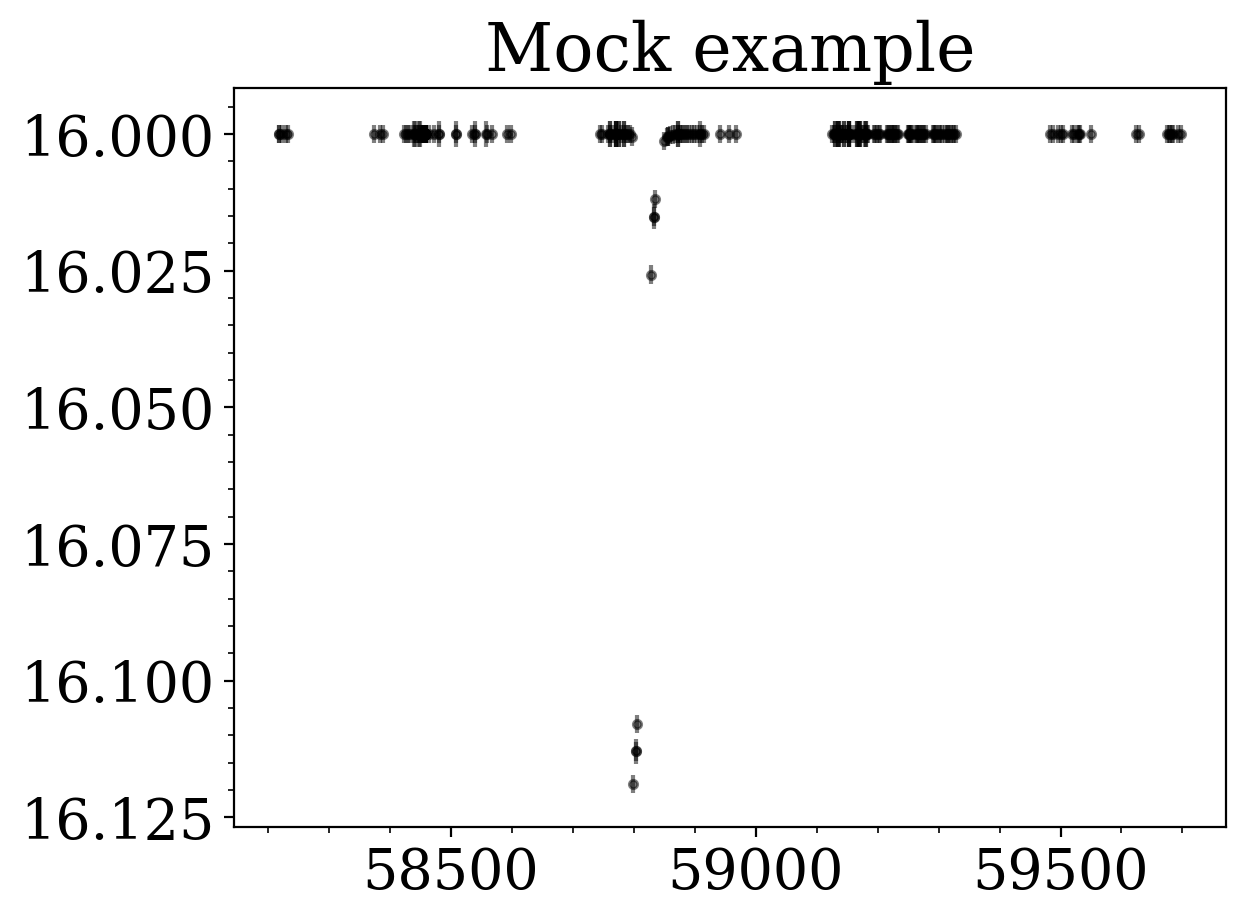

In [1009]:
plt.errorbar(time, model, yerr=model_err, fmt='.', 
            color='k', alpha=0.5)
plt.ylim(plt.ylim()[::-1])
plt.minorticks_on()
plt.title("Mock example")
#plt.xlim(np.median(time)+300-50, np.median(time)+300+50)

Text(0.5, 1.0, 'Mock example')

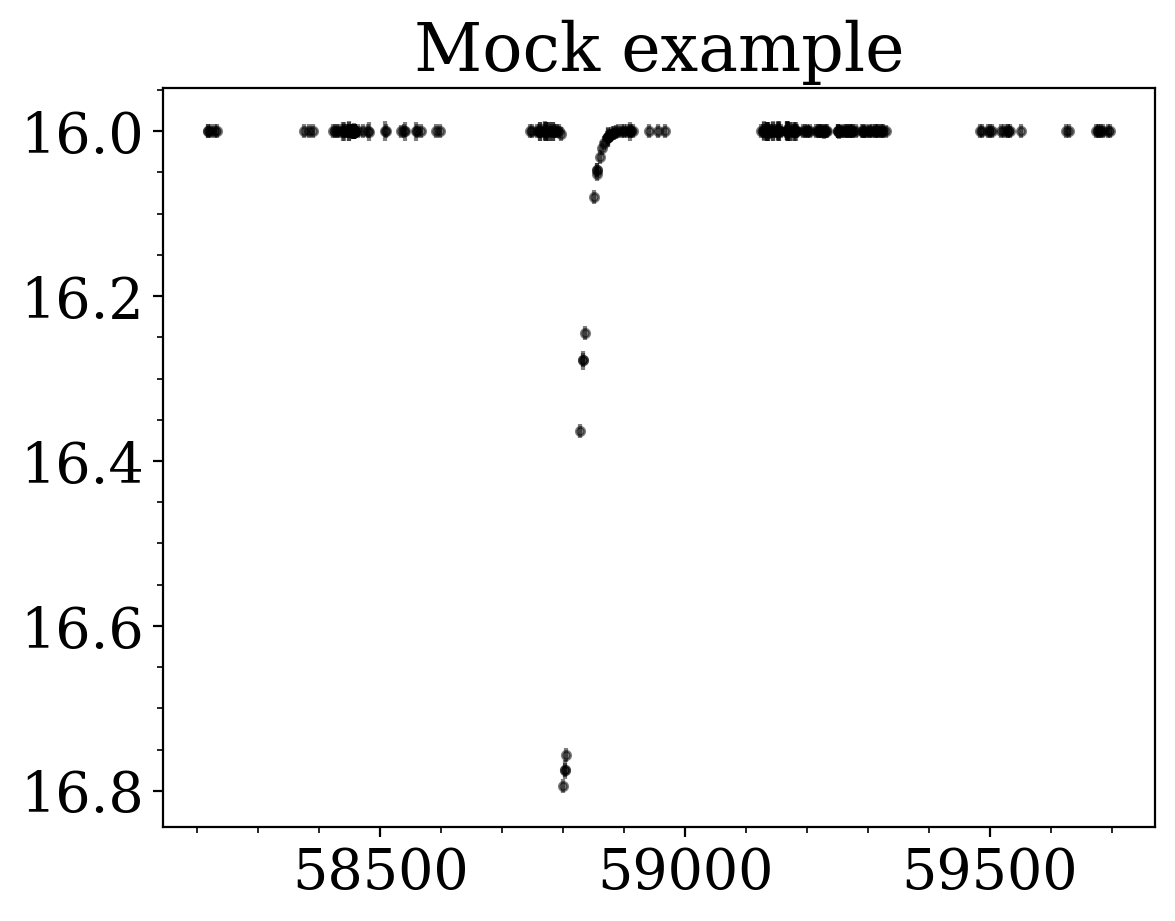

In [852]:
tb = pd.DataFrame([],columns=('mjd', 'mag', 'magerr', 'flag', 'band'))

In [853]:
tb['mjd'] = time
tb['mag'] = model
tb['magerr'] = model_err
tb['flag'] = np.zeros(len(time))
tb['band'] = ['r' for _ in range(len(time))]

In [854]:
evaluate(tb['mjd'], tb['mag'], tb['magerr'], tb['flag'], tb['band'], 
        np.array([121, 123]), np.array([31, 31.3]), gaia_lite, None)

{'assymetry_score': 163.72060606237912, 'left_error': 0.02711417888322459, 'right_error': 0.0013130027421399168, 'log_sum_error': 6.744194649155939, 'chi-square': 0.1535617365139034}


0         0.001037
1         0.019078
2         1.000000
3        68.490363
4     58776.476930
5     58783.498000
6     58598.145100
7         2.357344
8        15.000000
9       163.720606
10        0.153562
11       45.206441
12       18.010384
13       29.397590
14       18.249557
15     3436.372084
dtype: float64

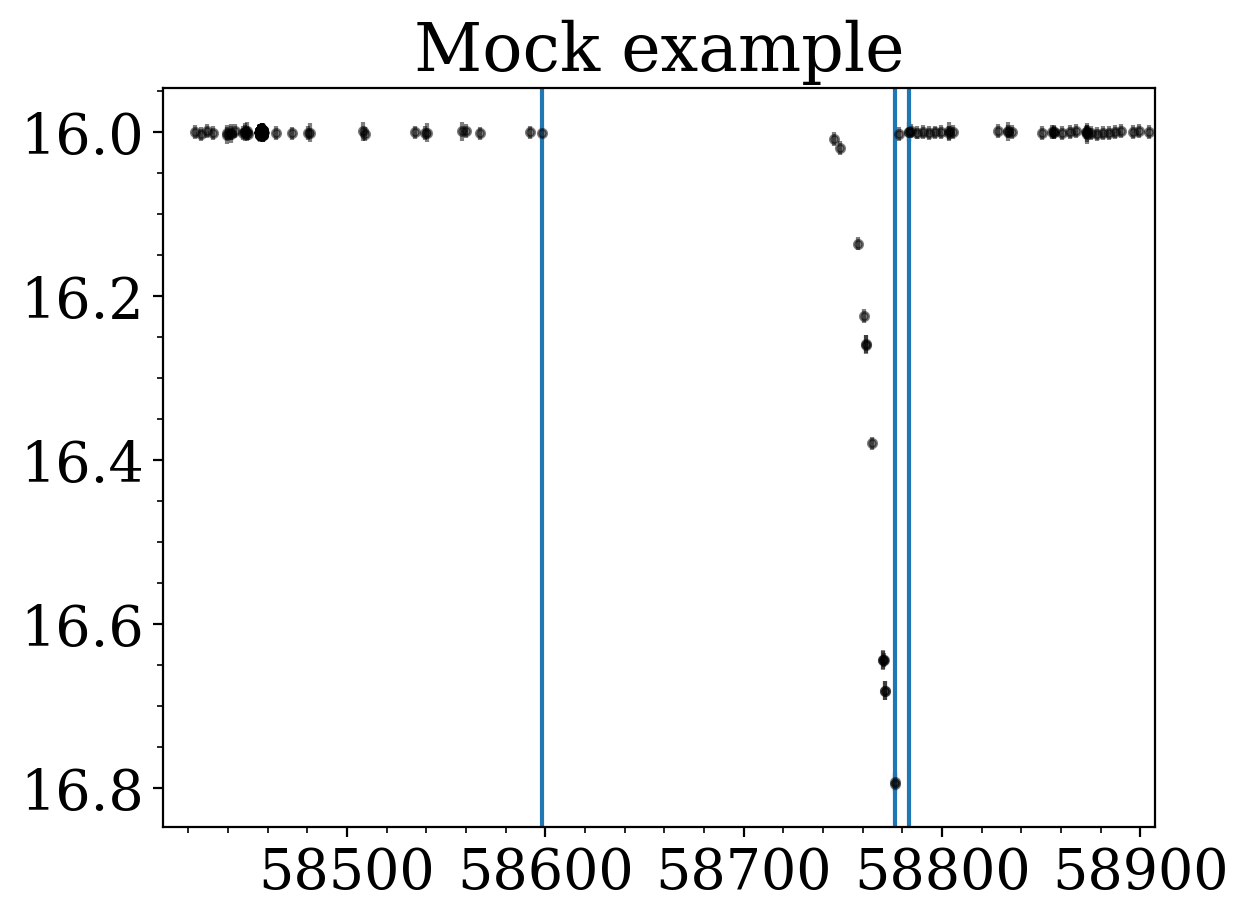

In [856]:
plt.errorbar(time, model, yerr=model_err, fmt='.', 
            color='k', alpha=0.5)
plt.ylim(plt.ylim()[::-1])
plt.minorticks_on()
plt.title("Mock example")
plt.xlim(np.median(time)+300-350, np.median(time)+300+150)
plt.axvline(58776.476930)
plt.axvline(58783.498000)
plt.axvline(58598.145100)

In [104]:
tbl = pd.read_parquet("/astro/users/atzanida/lrg_data/boyajiansearch/allsky/finalbatchv1.pq", engine='pyarrow')

In [121]:
for k in tbl.keys():
    print (k)

solution_id_gaia
designation_gaia
source_id_gaia
random_index_gaia
ref_epoch_gaia
ra_gaia
ra_error_gaia
dec_gaia
dec_error_gaia
parallax_gaia
parallax_error_gaia
parallax_over_error_gaia
pm_gaia
pmra_gaia
pmra_error_gaia
pmdec_gaia
pmdec_error_gaia
ra_dec_corr_gaia
ra_parallax_corr_gaia
ra_pmra_corr_gaia
ra_pmdec_corr_gaia
dec_parallax_corr_gaia
dec_pmra_corr_gaia
dec_pmdec_corr_gaia
parallax_pmra_corr_gaia
parallax_pmdec_corr_gaia
pmra_pmdec_corr_gaia
astrometric_n_obs_al_gaia
astrometric_n_obs_ac_gaia
astrometric_n_good_obs_al_gaia
astrometric_n_bad_obs_al_gaia
astrometric_gof_al_gaia
astrometric_chi2_al_gaia
astrometric_excess_noise_gaia
astrometric_excess_noise_sig_gaia
astrometric_params_solved_gaia
astrometric_primary_flag_gaia
nu_eff_used_in_astrometry_gaia
pseudocolour_gaia
pseudocolour_error_gaia
ra_pseudocolour_corr_gaia
dec_pseudocolour_corr_gaia
parallax_pseudocolour_corr_gaia
pmra_pseudocolour_corr_gaia
pmdec_pseudocolour_corr_gaia
astrometric_matched_transits_gaia
visibil

In [237]:
q = (tbl['Ndips']>0) & (tbl['integral_score']>250) & (~tbl['dip_cent'].duplicated())

In [284]:
tbl['dip_cent'].value_counts().values[0:10]

array([4766089,       9,       8,       7,       7,       6,       6,
             6,       6,       6])

In [353]:
count, bins = plt.np.histogram(tbl['dip_cent'][tbl['dip_cent']>0], 
            bins=np.arange(min(tbl['dip_cent'][tbl['dip_cent']>0]),
                           max(tbl['dip_cent']),
                           step=0.5))

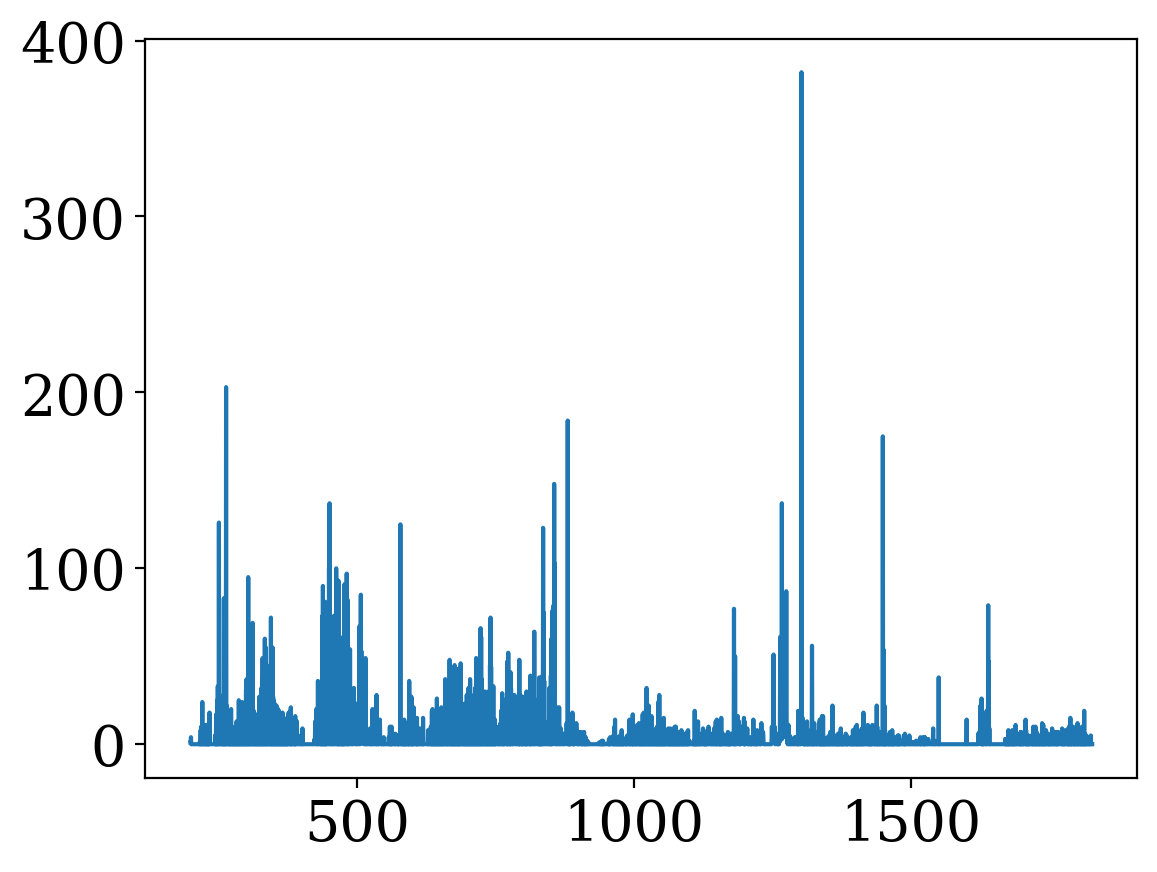

In [355]:
plt.plot(bins[1::]-58_000, count)

In [356]:
for i in range(0, len(count)):
    
    if count[i]>100:
        print (bins[i-1], bins[i+1])

58248.52098 58249.52098
58261.52098 58262.52098
58448.52098 58449.52098
58576.52098 58577.52098
58834.52098 58835.52098
58854.52098 58855.52098
58855.52098 58856.52098
58879.02098 58880.02098
59266.02098 59267.02098
59301.52098 59302.52098
59448.52098 59449.52098


Text(0.5, 0, 'N$_{dips}$')

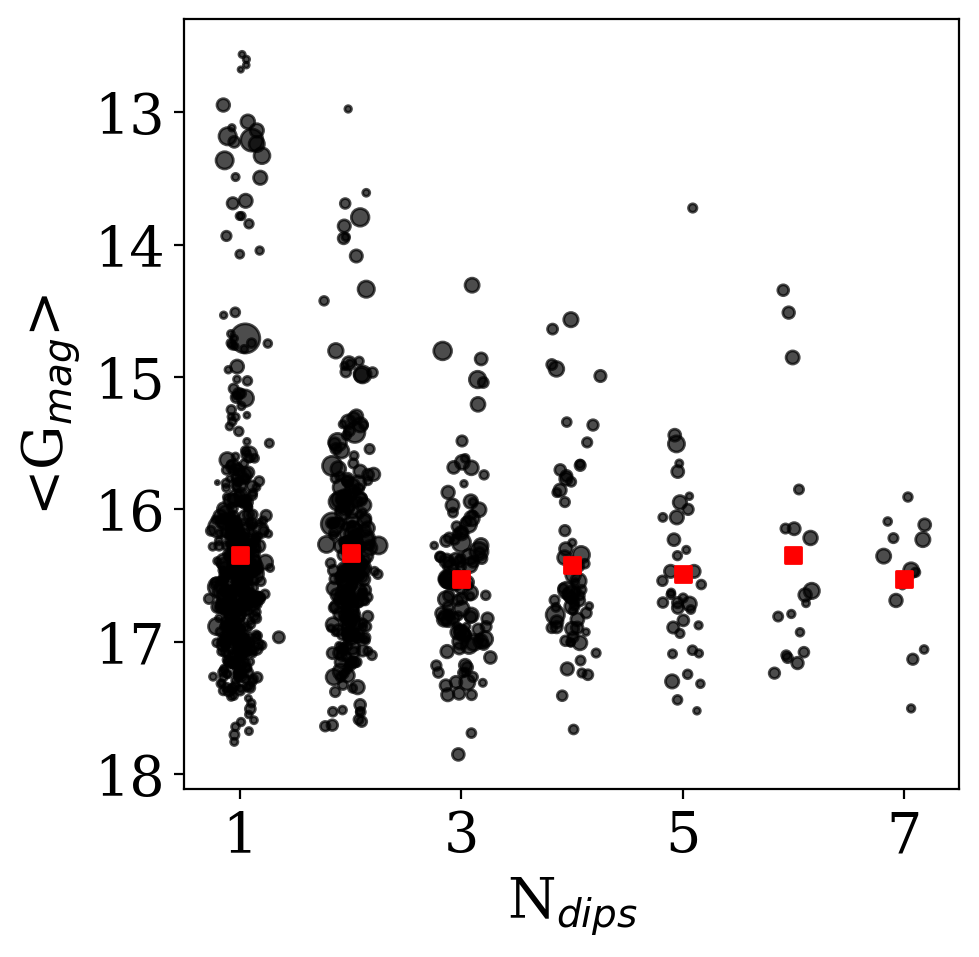

In [264]:
plt.figure(figsize=(5,5))
plt.scatter(tbl['Ndips'][q]+np.random.normal(0, 0.1, len(tbl['phot_g_mean_mag_gaia'][q])),
            tbl['phot_g_mean_mag_gaia'][q],
            s=tbl['best_dip_power'][q], 
           color='k', edgecolor='k', alpha=0.7)

for i in range(1, 9):
    qc = (tbl['Ndips']==i) & (tbl['integral_score']>250) & (~tbl['dip_cent'].duplicated())
        
    plt.scatter(i, np.mean(tbl['phot_g_mean_mag_gaia'][qc]), color='red', marker='s')


plt.ylim(plt.ylim()[::-1])
_ = plt.xticks(np.arange(1, 9, step=2))
plt.xlim(0.5, 7.5)
plt.ylabel("<G$_{mag}$>")
plt.xlabel("N$_{dips}$")

(18.11424525, 12.29972775)

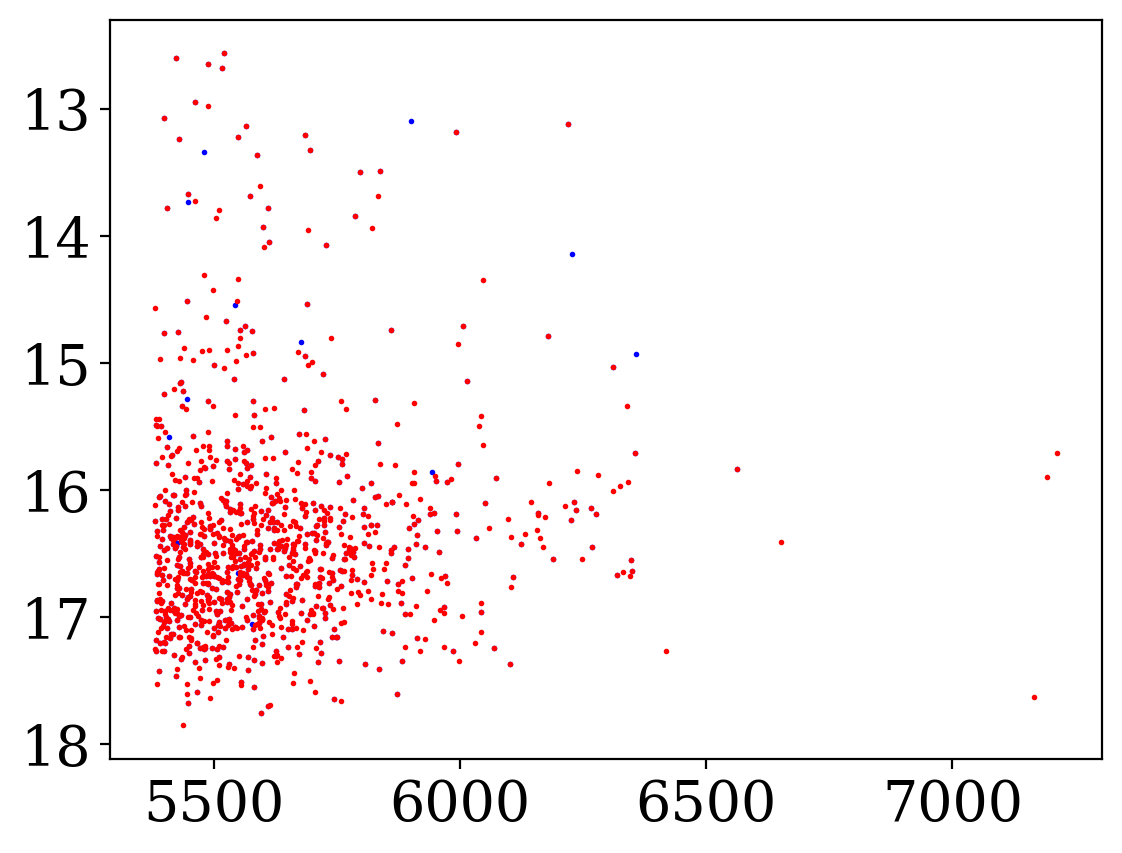

In [222]:
plt.scatter(tbl['teff_gspphot_gaia'][q2], (tbl['phot_g_mean_mag_gaia'][q2]), s=1, color='blue')
plt.scatter(tbl['teff_gspphot_gaia'][q], (tbl['phot_g_mean_mag_gaia'][q]), s=1, color='red')


plt.ylim(plt.ylim()[::-1])

Text(0, 0.5, 'Log(Dev)')

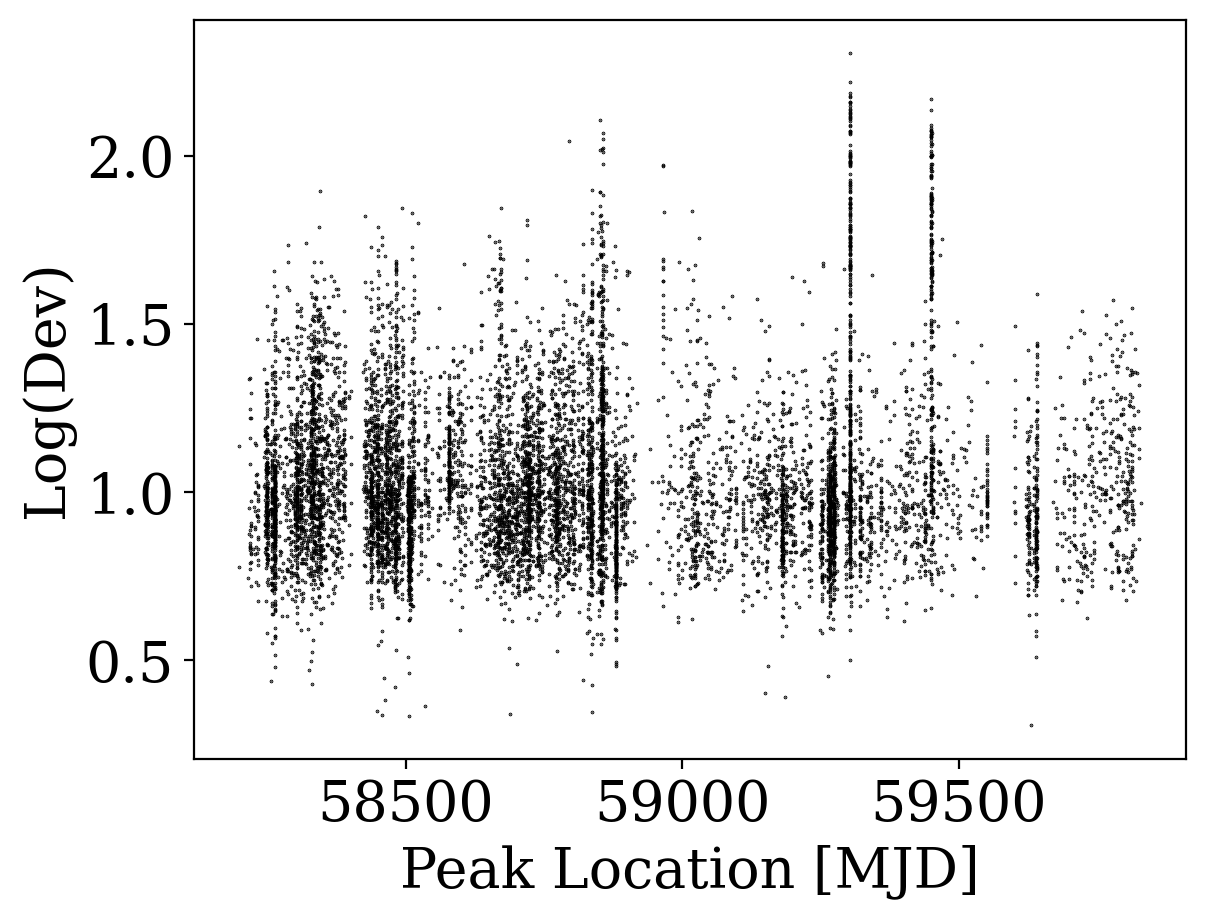

In [151]:
plt.scatter(tbl['dip_cent'][q], np.log10(tbl['best_dip_power'][q]), s=0.1, color='k')
plt.xlabel("Peak Location [MJD]")
plt.ylabel("Log(Dev)")

Text(0, 0.5, 'N$_{{stars}}$')

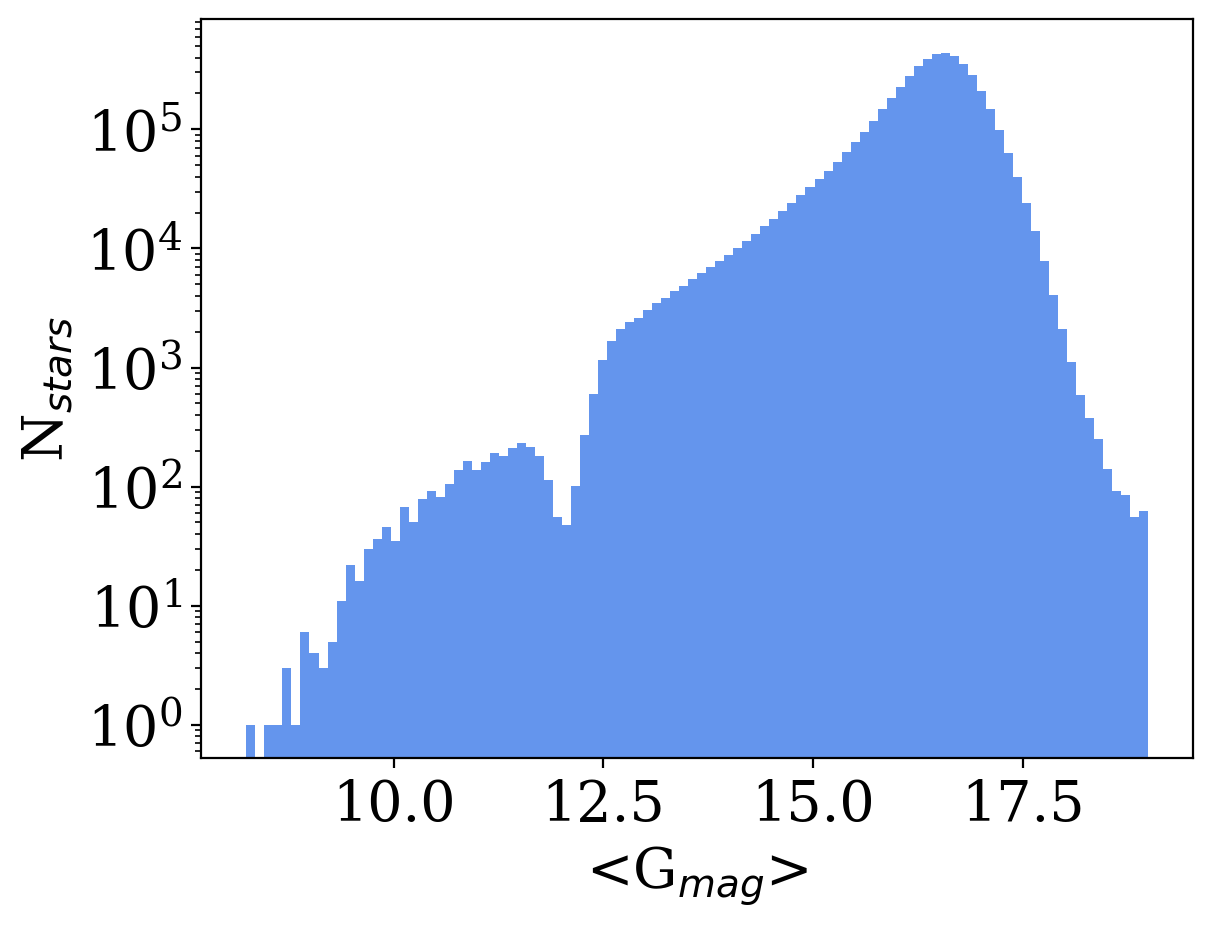

In [118]:
_ = plt.hist(tbl['phot_g_mean_mag_gaia'], bins=100, color='cornflowerblue')
plt.yscale('log')
plt.xlabel("<G$_{mag}$>")
plt.ylabel("N$_{{stars}}$")

In [119]:
tbl.head(2)

,solution_id_gaia,designation_gaia,source_id_gaia,random_index_gaia,ref_epoch_gaia,ra_gaia,ra_error_gaia,dec_gaia,dec_error_gaia,parallax_gaia,...,best_dip_power,best_dip_frac1sig,loc_dip_back,loc_dip_forward,dip_cent,integral_score,gp_logsum_err,left_integral_error,right_integral_error,len_in_window
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
10595126476800,1636148068921376768,Gaia DR3 5291399870976,5291399870976,651594654,2016.0,44.920804,0.056823,0.146074,0.048966,0.379842,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16507971043328,1636148068921376768,Gaia DR3 8250632981888,8250632981888,308268319,2016.0,44.998582,0.073726,0.230765,0.061019,0.734424,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
